In [2]:
import numpy as np
from collections import namedtuple, Counter
import ot
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.model_selection import GridSearchCV, train_test_split
from fairlearn.reductions import GridSearch, ExponentiatedGradient, EqualizedOdds
from fairlearn.metrics import group_recall_score, group_specificity_score
import matplotlib.pyplot as plt
import pickle
from cvxopt import matrix
from numpy import linalg
import cvxopt
import cvxopt.solvers
from sklearn.base import BaseEstimator
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.utils import resample
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = min(25, multiprocessing.cpu_count())

np.random.seed(101)

# TODO race as sel_feat
# TODO do scale binary features https://stackoverflow.com/questions/38420847/apply-standardscaler-to-parts-of-a-data-set/54322771#54322771
# TODO scale test using test data
# TODO no scaling of test and train

# Generate simulation data

In [3]:
def random_logit(x):
    z = 1./(1+np.exp(-x))
    s = np.random.binomial(n=1, p=z)

    return 2*s-1

def gen_synth_data(gamma_shift=0.0, gamma_A=0.0, C_src=0, C_tar=1, N=1000):
    '''Flu classification example
    Variables
    C: context 0 or 1
    A: age group 0 or 1
    R: risk
    T: temperature
    Y: flu 0 or 1'''
    
    # Regression coefficients
#     gamma_A = 0.0
        
    gamma_AC = 0.2
#     gamma_AC = np.random.normal(loc=0.8*(2*(np.random.uniform()<=0.5) - 1),\
#                                scale=0.64, size=1)
    gamma_RA = -0.1
#     gamma_RA = np.random.normal(loc=0.8*(2*(np.random.uniform()<=0.5) - 1),\
#                                scale=0.64, size=1)
    gamma_YA = -0.8
#     gamma_YA = np.random.normal(loc=0.8*(2*(np.random.uniform()<=0.5) - 1),\
#                                scale=0.64, size=1)
    gamma_YR = 0.8
#     gamma_YR = np.random.normal(loc=0.8*(2*(np.random.uniform()<=0.5) - 1),\
#                                scale=0.64, size=1)
    gamma_TC = 0.2
#     gamma_TC = np.random.normal(loc=0.8*(2*(np.random.uniform()<=0.5) - 1),\
#                                scale=0.64, size=1)
    gamma_TY = 0.8
#     gamma_TY = np.random.normal(loc=0.8*(2*(np.random.uniform()<=0.5) - 1),\
#                                scale=0.64, size=1)
    gamma_TR = 0.1
#     gamma_TR = np.random.normal(loc=0.8*(2*(np.random.uniform()<=0.5) - 1),\
#                                scale=0.64, size=1)
    gamma_TA = -0.8
#     gamma_TA = np.random.normal(loc=0.8*(2*(np.random.uniform()<=0.5) - 1),\
#                                scale=0.64, size=1)
    scale_A = 1.0
    scale_Y = 1.0

    # Source
    C_src_vec = np.repeat(a=C_src,repeats=N)
    A = random_logit(scale_A*(gamma_A + gamma_shift*gamma_AC*C_src_vec + np.random.normal(loc=0.0, scale=0.64, size=N)))
    R = gamma_RA*A + np.random.normal(loc=0.0, scale=1.64, size=N)
    Y_src = random_logit(scale_Y*(gamma_YA*A + gamma_YR*R + np.random.normal(loc=0.0, scale=0.64, size=N)))
    T = gamma_TY*Y_src + gamma_TR*R + gamma_TA*A + np.random.normal(loc=0.0, scale=1.96+gamma_shift*gamma_TC*C_src_vec, size=N)
    
    X_src = np.stack([A, R, T], axis=1)

    # Target
    C_tar_vec = np.repeat(a=C_tar,repeats=N)
    A = random_logit(scale_A*(gamma_A + gamma_shift*gamma_AC*C_tar_vec + np.random.normal(loc=0.0, scale=0.64, size=N)))
    R = gamma_RA*A + np.random.normal(loc=0.0, scale=1.64, size=N)
    Y_tar = random_logit(scale_Y*(gamma_YA*A + gamma_YR*R + np.random.normal(loc=0.0, scale=0.64, size=N)))
    T = gamma_TY*Y_tar + gamma_TR*R + gamma_TA*A + np.random.normal(loc=0.0, scale=1.96+gamma_shift*gamma_TC*C_tar_vec, size=N)
    
    X_tar = np.stack([A, R, T], axis=1)
    
    sensible_feature = 0 # A
    non_separating_feature = 2 # T
    
    print("Coefficients: g_shift:{},gA:{},gAC:{},gRA:{},gYA:{},gYR:{},gTC:{},gTY:{},gTR:{},gTA:{}"\
              .format(gamma_shift, gamma_A, gamma_AC, gamma_RA, gamma_YA, gamma_YR, gamma_TC, gamma_TY, gamma_TR, gamma_TA))
    return X_src,Y_src,X_tar,Y_tar,sensible_feature,non_separating_feature

def gen_synth_shift_data(gamma_shift_src=[0.0], gamma_shift_tar=[0.0], gamma_A=0.0, C_src=0, C_tar=1, N=1000, verbose=False):
    '''Flu classification example
    Variables
    C: context 0 or 1
    A: age group 0 or 1
    R: risk
    T: temperature
    Y: flu 0 or 1'''
    
    # Regression coefficients
#     gamma_A = 0.0
        
    gamma_AC = 0.2
#     gamma_AC = np.random.normal(loc=0.8*(2*(np.random.uniform()<=0.5) - 1),\
#                                scale=0.64, size=1)
    gamma_RA = -0.1
#     gamma_RA = np.random.normal(loc=0.8*(2*(np.random.uniform()<=0.5) - 1),\
#                                scale=0.64, size=1)
    gamma_YA = -0.8
#     gamma_YA = np.random.normal(loc=0.8*(2*(np.random.uniform()<=0.5) - 1),\
#                                scale=0.64, size=1)
    gamma_YR = 0.8
#     gamma_YR = np.random.normal(loc=0.8*(2*(np.random.uniform()<=0.5) - 1),\
#                                scale=0.64, size=1)
    gamma_TC = 0.2
#     gamma_TC = np.random.normal(loc=0.8*(2*(np.random.uniform()<=0.5) - 1),\
#                                scale=0.64, size=1)
    gamma_TY = 0.8
#     gamma_TY = np.random.normal(loc=0.8*(2*(np.random.uniform()<=0.5) - 1),\
#                                scale=0.64, size=1)
    gamma_TR = 0.1
#     gamma_TR = np.random.normal(loc=0.8*(2*(np.random.uniform()<=0.5) - 1),\
#                                scale=0.64, size=1)
    gamma_TA = -0.8
#     gamma_TA = np.random.normal(loc=0.8*(2*(np.random.uniform()<=0.5) - 1),\
#                                scale=0.64, size=1)
    scale_A = 1.0
    scale_Y = 1.0

    # Source datasets
    data_src = []
    for gamma_shift in gamma_shift_src:
        C_src_vec = np.repeat(a=C_src,repeats=N)
        A = random_logit(scale_A*(gamma_A + gamma_shift*gamma_AC*C_src_vec + np.random.normal(loc=0.0, scale=0.64, size=N)))
        R = gamma_RA*A + np.random.normal(loc=0.0, scale=1.64, size=N)
        Y_src = random_logit(scale_Y*(gamma_YA*A + gamma_YR*R + np.random.normal(loc=0.0, scale=0.64, size=N)))
        T = gamma_TY*Y_src + gamma_TR*R + gamma_TA*A + np.random.normal(loc=0.0, scale=1.96+gamma_shift*gamma_TC*C_src_vec, size=N)

        X_src = np.stack([A, R, T], axis=1)
        data_src.append((gamma_shift,X_src,Y_src))

    # Target datasets
    data_tar = []
    for gamma_shift in gamma_shift_tar:
        C_tar_vec = np.repeat(a=C_tar,repeats=N)
        A = random_logit(scale_A*(gamma_A + gamma_shift*gamma_AC*C_tar_vec + np.random.normal(loc=0.0, scale=0.64, size=N)))
        R = gamma_RA*A + np.random.normal(loc=0.0, scale=1.64, size=N)
        Y_tar = random_logit(scale_Y*(gamma_YA*A + gamma_YR*R + np.random.normal(loc=0.0, scale=0.64, size=N)))
        T = gamma_TY*Y_tar + gamma_TR*R + gamma_TA*A + np.random.normal(loc=0.0, scale=1.96+gamma_shift*gamma_TC*C_tar_vec, size=N)

        X_tar = np.stack([A, R, T], axis=1)
        data_tar.append((gamma_shift,X_tar,Y_tar))
        
    sensible_feature = 0 # A
    non_separating_feature = 2 # T
    
    if verbose:
        print("Coefficients: g_shift:{},gA:{},gAC:{},gRA:{},gYA:{},gYR:{},gTC:{},gTY:{},gTR:{},gTA:{}"\
                  .format(gamma_shift, gamma_A, gamma_AC, gamma_RA, gamma_YA, gamma_YR, gamma_TC, gamma_TY, gamma_TR, gamma_TA))
    return data_src,data_tar,sensible_feature,non_separating_feature

def load_synth(data, target, data_test, target_test, smaller=False, scaler=True):
    len_train = len(data[:, -1])
    if scaler:
        scaler = StandardScaler()
        scaler.fit(data)
        data = scaler.transform(data)
        data_test = scaler.transform(data_test)
    if smaller:
        print('A smaller version of the dataset is loaded...')
        data = namedtuple('_', 'data, target')(data[:len_train // 20, :-1], target[:len_train // 20])
        data_test = namedtuple('_', 'data, target')(data_test, target_test)
    else:
        data = namedtuple('_', 'data, target')(data, target)
        data_test = namedtuple('_', 'data, target')(data_test, target_test)
    return data, data_test

def load_data_file(filename, samp_prop=1.0):
    
    with open(filename) as fr:
        dataset_df = pd.read_csv(fr)
        
    # https://stackoverflow.com/questions/46433588/pandas-drop-rows-columns-if-more-than-half-are-nan
    col_less_half_nan = dataset_df.count(axis=0) < 0.1*dataset_df.shape[0] # count ignores nan
    print("Columns removed with >90% nans", col_less_half_nan[col_less_half_nan==True])

    dataset_df = dataset_df.drop(columns=col_less_half_nan[col_less_half_nan].keys())
    print("Size of full dataset", dataset_df.shape)
    
    data = dataset_df.values
    
    if samp_prop<1.0:
        print('Subsampling data with ratio', samp_prop)
        n_samples = int(np.ceil(samp_prop*data.shape[0]))
        data = resample(data, n_samples=n_samples, replace=False, random_state=101)
    else:
        print('Loading all data. No subsampling')
        
    # np.random.shuffle(data)

    features = data[:,0:-1] # remove target
    target = data[:,-1].astype(int)

    return features, target

# Shift test, original train
def gen_synth_test_shift_real_data(all_features, all_target, sensible_feature, non_separating_feature, intv_col, missing_ind_col, sel_col,\
                              test_prop, val_prop, intv_prop_src=[0.0], intv_prop_tar=[0.5], sel_prop=0.5,\
                              smaller=False, impute=True, scaler=True):
    '''
    # TODO: assumes only one value for sel_prop
    Create multiple shifted test sets by adding missing values and undersampling
    :param intv_prop_src: for source dataset, different percentages of rows to intervene on by adding missing values
    :param intv_prop_tar: for target datasets, different percentages of rows to intervene on by adding missing values
    :param sel_prop: proportion of rows to select to add selection bias
    '''
    # random_state not set so that train-test is different each time
    data, data_test, target, target_test = train_test_split(all_features, all_target, test_size=test_prop)

    len_train = len(data[:, -1])
    len_test = len(data_test[:, -1])
    
    data, data_val, target, target_val = train_test_split(data, target, test_size=val_prop)

    if impute:
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        imputer.fit(data)
        data = imputer.transform(data)
        data_val = imputer.transform(data_val)
    if scaler:
        scaler = StandardScaler()
        scaler.fit(data)
        data = scaler.transform(data)
        data_val = scaler.transform(data_val)
    if smaller:
        print('A smaller version of the dataset is loaded...')
        data = namedtuple('_', 'data, target')(data[:len_train // 20, :-1], target[:len_train // 20])
        data_val = namedtuple('_', 'data, target')(data_val, target_val)
    else:
        print('The dataset is loaded...')
        data = namedtuple('_', 'data, target')(data, target)
        data_val = namedtuple('_', 'data, target')(data_val, target_val)
    
    # Source (train) datasets
    data_src_train = [] # TODO: only one source dataset with no shift
    for intv_prop in intv_prop_src:
        data_src_train.append((intv_prop, sel_prop, data)) # TODO: intv_prop assumed to be 0.0
    
    # Source (validation) datasets
    data_src_val = [] # TODO: only one source dataset with no shift
    for intv_prop in intv_prop_src:
        data_src_val.append((intv_prop, sel_prop, data_val)) # TODO: intv_prop assumed to be 0.0

    # Target datasets
    data_tar = []
    for intv_prop in intv_prop_tar:
        
        data_test_tmp = data_test.copy()
        target_test_tmp = target_test.copy()
        
        print("\n\nCreating synthetically shifted data for intv_prop:{}".format(intv_prop))
        
        # Intervention
        print("Original nans", np.isnan(np.array(data_test_tmp[:, intv_col],dtype=float)).sum())
        missed_rows = np.random.choice(data_test_tmp.shape[0], int(len_test*intv_prop), replace=False)
        data_test_tmp[missed_rows, intv_col] = np.nan
        if missing_ind_col!=None:
            data_test_tmp[missed_rows, missing_ind_col] = 0
    #     data_test_tmp[:, intv_col] += np.random.normal(0.0, intv_prop, len_test)
        print("After missing nans", np.isnan(np.array(data_test_tmp[:, intv_col],dtype=float)).sum())

        # Selection
        print("Original demographic", Counter(data_test_tmp[:, sel_col]))
        print("Original class", Counter(target_test_tmp))
        sel_rows = np.array([np.random.binomial(1, sel_prop)==1 if data_test_tmp[i, sel_col]==1.0 else True\
                        for i in np.arange(data_test_tmp.shape[0])], dtype=bool)
        data_test_tmp = data_test_tmp[sel_rows, :]
        target_test_tmp = target_test_tmp[sel_rows]
        print("After selection demographic", Counter(data_test_tmp[:, sel_col]))
        print("After selection class", Counter(target_test_tmp))
        
        if impute:
            data_test_tmp = imputer.transform(data_test_tmp)
        if scaler:
            data_test_tmp = scaler.transform(data_test_tmp)
        if smaller:
            data_test_tmp = namedtuple('_', 'data, target')(data_test_tmp, target_test_tmp)
        else:
            data_test_tmp = namedtuple('_', 'data, target')(data_test_tmp, target_test_tmp)
    
        data_tar.append((intv_prop, sel_prop, data_test_tmp))
    
    print("Coefficients: intv_col:{},missing_ind_col:{},sel_col:{},intv_prop_src:{},intv_prop_tar:{},sel_prop:{},sensible_feature:{},non_separating_feature:{}"\
                  .format(intv_col, missing_ind_col, sel_col, intv_prop_src, intv_prop_tar, sel_prop, sensible_feature, non_separating_feature))
        
    return data_src_train, data_src_val, data_tar

# Shift train, original test
def gen_synth_train_shift_real_data(all_features, all_target, sensible_feature, non_separating_feature, intv_col, missing_ind_col, sel_col,\
                              test_prop, val_prop, intv_prop_src=[0.0], intv_prop_tar=[0.5], sel_prop=0.5,\
                              smaller=False, impute=True, scaler=True):
    '''
    # TODO: assumes only one value for sel_prop
    Create multiple shifted train sets by adding missing values and undersampling
    :param intv_prop_src: for source dataset, different percentages of rows to intervene on by adding missing values
    :param intv_prop_tar: for target datasets, different percentages of rows to intervene on by adding missing values
    :param sel_prop: proportion of rows to select to add selection bias
    '''
    # random_state not set so that train-test is different each time
    data, data_test, target, target_test = train_test_split(all_features, all_target, test_size=test_prop)

    len_train = len(data[:, -1])
    len_test = len(data_test[:, -1])

    # Source and target datasets
    data_src_train = []
    data_src_val = []
    data_tar = [] # TODO: assumes only one target dataset with no shift
    
    intv_prop_src_tar = [(psrc,ptar) for psrc in intv_prop_src for ptar in intv_prop_tar]
    for intv_psrc, intv_ptar in intv_prop_src_tar:
        data_tmp = data.copy()
        target_tmp = target.copy()
        data_test_tmp = data_test.copy()
        target_test_tmp = target_test.copy()
        
        print("\n\nCreating synthetically shifted data for intv_prop:{}".format(intv_psrc))
        
        # Intervention
        print("Original nans in train", np.isnan(np.array(data_tmp[:, intv_col],dtype=float)).sum())
        missed_rows = np.random.choice(data_tmp.shape[0], int(len_train*intv_psrc), replace=False)
        data_tmp[missed_rows, intv_col] = np.nan
        if missing_ind_col!=None:
            data_tmp[missed_rows, missing_ind_col] = 0
    #     data_tmp[:, intv_col] += np.random.normal(0.0, intv_psrc, len_train)
        print("After missing nans in train", np.isnan(np.array(data_tmp[:, intv_col],dtype=float)).sum())

        # Selection
        print("Original demographic in train", Counter(data_tmp[:, sel_col]))
        print("Original class in train", Counter(target_tmp))
        sel_rows = np.array([np.random.binomial(1, sel_prop)==1 if data_tmp[i, sel_col]==1.0 else True\
                        for i in np.arange(data_tmp.shape[0])], dtype=bool)
        data_tmp = data_tmp[sel_rows, :]
        target_tmp = target_tmp[sel_rows]
        print("After selection demographic in train", Counter(data_tmp[:, sel_col]))
        print("After selection class in train", Counter(target_tmp))
        
        if impute:
            imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
            imputer.fit(data_tmp)
            data_tmp = imputer.transform(data_tmp)
            data_test_tmp = imputer.transform(data_test_tmp)
        if scaler:
            scaler = StandardScaler()
            scaler.fit(data_tmp)
            data_tmp = scaler.transform(data_tmp)
            data_test_tmp = scaler.transform(data_test_tmp)
        
        # Split train into train and val
        data_tmp, data_val_tmp, target_tmp, target_val_tmp = train_test_split(data_tmp, target_tmp, test_size=val_prop)
        
        if smaller:
            print('A smaller version of the dataset is loaded...')
            data_tmp = namedtuple('_', 'data, target')(data_tmp[:len_train // 20, :-1], target_tmp[:len_train // 20])
            data_val_tmp = namedtuple('_', 'data, target')(data_val_tmp, target_val_tmp)
            data_test_tmp = namedtuple('_', 'data, target')(data_test_tmp, target_test_tmp)
        else:
            print('The dataset is loaded...')            
            data_tmp = namedtuple('_', 'data, target')(data_tmp, target_tmp)
            data_val_tmp = namedtuple('_', 'data, target')(data_val_tmp, target_val_tmp)
            data_test_tmp = namedtuple('_', 'data, target')(data_test_tmp, target_test_tmp)
    
        data_src_train.append((intv_psrc, sel_prop, data_tmp))
        data_src_val.append((intv_psrc, sel_prop, data_val_tmp))
        data_tar.append((intv_ptar, sel_prop, data_test_tmp)) # TODO: intv_ptar assumed to be 0.0
    
    print("Coefficients: intv_col:{},missing_ind_col:{},sel_col:{},intv_prop_src:{},intv_prop_tar:{},sel_prop:{},sensible_feature:{},non_separating_feature:{}"\
                  .format(intv_col, missing_ind_col, sel_col, intv_prop_src, intv_prop_tar, sel_prop, sensible_feature, non_separating_feature))
        
    return data_src_train, data_src_val, data_tar

# Selection in train, missing values in test
def gen_synth_train_sel_test_shift_real_data(all_features, all_target, sensible_feature, non_separating_feature, intv_col, missing_ind_col, sel_col,\
                              test_prop, val_prop, intv_prop_src=[0.0], intv_prop_tar=[0.5], sel_prop=0.5,\
                              smaller=False, impute=True, scaler=True):
    '''
    # TODO: assumes only one value for sel_prop
    Create multiple shifted train sets by adding missing values and undersampling
    :param intv_prop_src: for source dataset, different percentages of rows to intervene on by adding missing values
    :param intv_prop_tar: for target datasets, different percentages of rows to intervene on by adding missing values
    :param sel_prop: proportion of rows to select to add selection bias
    '''
    # random_state not set so that train-test is different each time
    data, data_test, target, target_test = train_test_split(all_features, all_target, test_size=test_prop)

    len_train = len(data[:, -1])
    len_test = len(data_test[:, -1])

    # Source and target datasets
    data_src_train = [] # TODO: assumes only one source dataset with only selection bias
    data_src_val = [] # TODO: assumes only one source dataset with only selection bias
    data_tar = []
    
    intv_prop_src_tar = [(psrc,ptar) for psrc in intv_prop_src for ptar in intv_prop_tar]
    for intv_psrc, intv_ptar in intv_prop_src_tar:
        data_tmp = data.copy()
        target_tmp = target.copy()
        data_test_tmp = data_test.copy()
        target_test_tmp = target_test.copy()
        
        print("\n\nCreating synthetically shifted data for intv_prop:{}".format(intv_ptar))
        
        # Intervention
        print("Original nans in test", np.isnan(np.array(data_test_tmp[:, intv_col],dtype=float)).sum())
        missed_rows = np.random.choice(data_test_tmp.shape[0], int(len_test*intv_ptar), replace=False)
        data_test_tmp[missed_rows, intv_col] = np.nan
        if missing_ind_col!=None:
            data_test_tmp[missed_rows, missing_ind_col] = 0
    #     data_tmp[:, intv_col] += np.random.normal(0.0, intv_psrc, len_train)
        print("After missing nans in test", np.isnan(np.array(data_test_tmp[:, intv_col],dtype=float)).sum())

        # Selection
        print("Original demographic in train", Counter(data_tmp[:, sel_col]))
        print("Original class in train", Counter(target_tmp))
        sel_rows = np.array([np.random.binomial(1, sel_prop)==1 if data_tmp[i, sel_col]==1.0 else True\
                        for i in np.arange(data_tmp.shape[0])], dtype=bool)
        data_tmp = data_tmp[sel_rows, :]
        target_tmp = target_tmp[sel_rows]
        print("After selection demographic in train", Counter(data_tmp[:, sel_col]))
        print("After selection class in train", Counter(target_tmp))
        
        if impute:
            imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
            imputer.fit(data_tmp)
            data_tmp = imputer.transform(data_tmp)
            data_test_tmp = imputer.transform(data_test_tmp)
        if scaler:
            scaler = StandardScaler()
            scaler.fit(data_tmp)
            data_tmp = scaler.transform(data_tmp)
            data_test_tmp = scaler.transform(data_test_tmp)
        
        # Split train into train and val
        data_tmp, data_val_tmp, target_tmp, target_val_tmp = train_test_split(data_tmp, target_tmp, test_size=val_prop)
        
        if smaller:
            print('A smaller version of the dataset is loaded...')
            data_tmp = namedtuple('_', 'data, target')(data_tmp[:len_train // 20, :-1], target_tmp[:len_train // 20])
            data_val_tmp = namedtuple('_', 'data, target')(data_val_tmp, target_val_tmp)
            data_test_tmp = namedtuple('_', 'data, target')(data_test_tmp, target_test_tmp)
        else:
            print('The dataset is loaded...')            
            data_tmp = namedtuple('_', 'data, target')(data_tmp, target_tmp)
            data_val_tmp = namedtuple('_', 'data, target')(data_val_tmp, target_val_tmp)
            data_test_tmp = namedtuple('_', 'data, target')(data_test_tmp, target_test_tmp)
    
        data_src_train.append((intv_psrc, sel_prop, data_tmp))
        data_src_val.append((intv_psrc, sel_prop, data_val_tmp))
        data_tar.append((intv_ptar, sel_prop, data_test_tmp)) # TODO: intv_ptar assumed to be 0.0
    
    print("Coefficients: intv_col:{},missing_ind_col:{},sel_col:{},intv_prop_src:{},intv_prop_tar:{},sel_prop:{},sensible_feature:{},non_separating_feature:{}"\
                  .format(intv_col, missing_ind_col, sel_col, intv_prop_src, intv_prop_tar, sel_prop, sensible_feature, non_separating_feature))
        
    return data_src_train, data_src_val, data_tar

# Fairness measure

In [4]:
def equalized_odds_measure_TP(data, model, sensitive_features, ylabel, rev_pred=1):
    '''
    True positive label for the groups defined by the values of the "sensible_features",
    with respect to the "model" on the "data".
    :param data: the data where to evaluate the True Positive Rate (Equal Opportunity).
    :param model:  the model that has to be evaluated.
    :param sensitive_features: the features used to split the data in groups.
    :param ylabel: the POSITIVE label (usually +1).
    :param rev_pred: an option to reverse the outputs of our model.
    :return: a dictionary with keys the sensitive_features and values dictionaries containing the True Positive Rates
    of the different subgroups of the specific sensitive feature.
    '''
    predictions = model.predict(data.data) * rev_pred
    truth = data.target
    eq_dict = {}
    for feature in sensitive_features:
        eq_sensible_feature = {}
        values_of_sensible_feature = list(set(data.data[:, feature]))
        for val in values_of_sensible_feature:
            eq_tmp = None
            positive_sensitive = np.sum([1.0 if data.data[i, feature] == val and truth[i] == ylabel else 0.0
                                         for i in range(len(predictions))])
            if positive_sensitive > 0:
                eq_tmp = np.sum([1.0 if predictions[i] == ylabel and data.data[i, feature] == val and truth[i] == ylabel
                                 else 0.0 for i in range(len(predictions))]) / positive_sensitive
            eq_sensible_feature[val] = eq_tmp
        eq_dict[feature] = eq_sensible_feature
    return eq_dict

def max_equalized_odds_violation(target, predictions, sensitive_feature):
    '''
    Maximum violation of equalized odds constraint. From fair reductions paper,
    max_{y,a} |E[h(X)|Y=y,A=a]-E[h(X)|Y=y]|
    :param sensitive_feature: actual value of the sensitive feature
    '''
    tpr = group_recall_score(target, predictions, sensitive_feature)
    specificity = group_specificity_score(target, predictions, sensitive_feature) # 1-fpr
    
    max_violation = max([abs(tpr_group-tpr.overall) for tpr_group in tpr.by_group.values()] +
        [abs(spec_group-specificity.overall) for spec_group in specificity.by_group.values()])
    
    return max_violation

# Classifier with fair ERM

In [5]:
class Linear_FERM:
    # The linear FERM algorithm
    def __init__(self, dataset, model, sensible_feature):
        self.dataset = dataset
        self.values_of_sensible_feature = list(set(dataset.data[:, sensible_feature]))
        self.list_of_sensible_feature_train = dataset.data[:, sensible_feature]
        self.val0 = np.min(self.values_of_sensible_feature)
        self.val1 = np.max(self.values_of_sensible_feature)
        self.model = model
        self.sensible_feature = sensible_feature
        self.u = None

    def new_representation(self, examples):
        if self.u is None:
            tmp = [ex for idx, ex in enumerate(self.dataset.data)
                   if self.dataset.target[idx] == 1 and ex[self.sensible_feature] == self.val1]
            average_A_1 = np.mean(tmp, 0)
            tmp = [ex for idx, ex in enumerate(self.dataset.data)
                   if self.dataset.target[idx] == 1 and ex[self.sensible_feature] == self.val0]
            average_not_A_1 = np.mean(tmp, 0)
            self.u = -(average_A_1 - average_not_A_1)
        new_examples = np.array([ex if ex[self.sensible_feature] == self.val0 else ex + self.u for ex in examples])
        new_examples = np.delete(new_examples, self.sensible_feature, 1)
        return new_examples

    def predict(self, examples):
        if self.u is None:
            print('Model not trained yet!')
            return 0
        new_examples = np.array([ex if ex[self.sensible_feature] == self.val0 else ex + self.u for ex in examples])
        new_examples = np.delete(new_examples, self.sensible_feature, 1)
        prediction = self.model.predict(new_examples)
        return prediction

    def decision_function(self, examples):
        if self.u is None:
            print('Model not trained yet!')
            return 0
        new_examples = np.array([ex if ex[self.sensible_feature] == self.val0 else ex + self.u for ex in examples])
        new_examples = np.delete(new_examples, self.sensible_feature, 1)
        score = self.model.decision_function(new_examples)
        return score
    
    def fit(self):
        # Evaluation of the empirical averages among the groups
        tmp = [ex for idx, ex in enumerate(self.dataset.data)
               if self.dataset.target[idx] == 1 and ex[self.sensible_feature] == self.val1]
        average_A_1 = np.mean(tmp, 0)
        tmp = [ex for idx, ex in enumerate(self.dataset.data)
               if self.dataset.target[idx] == 1 and ex[self.sensible_feature] == self.val0]
        average_not_A_1 = np.mean(tmp, 0)

        # Evaluation of the vector u (difference among the two averages)
        self.u = -(average_A_1 - average_not_A_1)

        # Application of the new representation
        newdata = np.array([ex if ex[self.sensible_feature] == self.val0 else ex + self.u for ex in self.dataset.data])
        newdata = np.delete(newdata, self.sensible_feature, 1)
        self.dataset = namedtuple('_', 'data, target')(newdata, self.dataset.target)

        # Fitting the linear model by using the new data
        self.model.fit(self.dataset.data, self.dataset.target)
        
# Definition of different kernels
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def gaussian_kernel(x, y, gamma=0.1):
    return np.exp(-gamma * (linalg.norm(x - y)**2))


class FERM(BaseEstimator):
    # FERM algorithm
    def __init__(self, kernel='rbf', C=1.0, sensible_feature=None, gamma=1.0):
        self.kernel = kernel
        self.C = C
        self.fairness = False if sensible_feature is None else True
        self.sensible_feature = sensible_feature
        self.gamma = gamma
        self.w = None

    def fit(self, X, y):
        if self.kernel == 'rbf':
            self.fkernel = lambda x, y: rbf_kernel(x, y, self.gamma)
        elif self.kernel == 'linear':
            self.fkernel = linear_kernel
        else:
            self.fkernel = linear_kernel

        if self.fairness:
            self.values_of_sensible_feature = list(set(X[:, self.sensible_feature]))
            self.list_of_sensible_feature_train = X[:, self.sensible_feature]
            self.val0 = np.min(self.values_of_sensible_feature)
            self.val1 = np.max(self.values_of_sensible_feature)
            self.set_A1 = [idx for idx, ex in enumerate(X) if y[idx] == 1
                           and ex[self.sensible_feature] == self.val1]
            self.set_not_A1 = [idx for idx, ex in enumerate(X) if y[idx] == 1
                               and ex[self.sensible_feature] == self.val0]
            self.set_1 = [idx for idx, ex in enumerate(X) if y[idx] == 1]
            self.n_A1 = len(self.set_A1)
            self.n_not_A1 = len(self.set_not_A1)
            self.n_1 = len(self.set_1)

        n_samples, n_features = X.shape

        # Gram matrix
        K = self.fkernel(X, X.T)

        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        # print(y)
        A = cvxopt.matrix(y.astype(np.double), (1, n_samples), 'd')
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # Stack the fairness constraint
        if self.fairness:
            tau = [(np.sum(K[self.set_A1, idx]) / self.n_A1) - (np.sum(K[self.set_not_A1, idx]) / self.n_not_A1)
                   for idx in range(len(y))]
            fairness_line = matrix(y * tau, (1, n_samples), 'd')
            A = cvxopt.matrix(np.vstack([A, fairness_line]))
            b = cvxopt.matrix([0.0, 0.0])

        # solve QP problem
        cvxopt.solvers.options['show_progress'] = False
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-7
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        # print("%d support vectors out of %d points" % (len(self.a), n_samples))

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n], sv])
        self.b /= len(self.a)

        # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None

    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            XSV = self.fkernel(X, self.sv)
            a_sv_y = np.multiply(self.a, self.sv_y)
            y_predict = [np.sum(np.multiply(np.multiply(self.a, self.sv_y), XSV[i, :])) for i in range(len(X))]

            return y_predict + self.b

    def decision_function(self, X):
        return self.project(X)

    def predict(self, X):
        return np.sign(self.project(X))

    def score(self, X_test, y_test):
        predict = self.predict(X_test)
        acc = accuracy_score(y_test, predict)
        return acc

# Synthetic data experiment with domain adaptable classifiers

In [6]:
def single_experiment(gamma_shift, gamma_A, C_src, C_tar, N, verbose=False):
    CV_FOLDS = 5
    
    # Generate source (train) and target (test) data
    X,Y,X_test,Y_test,sensible_feature,non_separating_feature = gen_synth_data(gamma_shift, gamma_A, C_src, C_tar, N)
    dataset_train, dataset_test = load_synth(X, Y, X_test, Y_test, smaller=False, scaler=True)
    # sensible_feature = 0  # A
    sensible_feature_values = sorted(list(set(dataset_train.data[:, sensible_feature])))
    if verbose:
        print('Different values of the sensible feature', sensible_feature, ':', sensible_feature_values)
    print('Number of examples in each level of the sensible feature', sensible_feature, ':',\
          Counter(dataset_train.data[:, sensible_feature]), Counter(dataset_test.data[:, sensible_feature]),\
          'test ratio:', [(x,y/len(dataset_test.data)) for (x,y) in Counter(dataset_test.data[:, sensible_feature]).items()])
    print('Number of examples in each class in train:',\
          Counter(dataset_train.target), 'test:', Counter(dataset_test.target),\
          'test ratio:', [(x,y/len(dataset_test.target)) for (x,y) in Counter(dataset_test.target).items()])
    D_tmp = dataset_test.data[:, sensible_feature]
    sensible_feature_ratio = Counter(D_tmp)[max(D_tmp)]/len(D_tmp)
    class_ratio = Counter(dataset_test.target)[1]/len(dataset_test.target)
    ntrain = len(dataset_train.target)
    if verbose:
        print('Sensible feature ratio test', sensible_feature_ratio)
        print('Class ratio test:', class_ratio)

    # Standard SVM -  Train an SVM using the training set
    if verbose:
        print('\n\n\nGrid search...')
    param_grid = [{'C': [0.01, 0.1, 1.0], 'kernel': ['linear']}]
    svc = svm.SVC()
    clf_std = GridSearchCV(svc, param_grid, n_jobs=1, cv=CV_FOLDS)
    clf_std.fit(dataset_train.data, dataset_train.target)
    if verbose:
        print('Best Estimator:', clf_std.best_estimator_)
        print('Params:', clf_std.best_estimator_.intercept_, clf_std.best_estimator_.coef_)

    # Accuracy and Fairness
    pred = clf_std.predict(dataset_test.data)
    pred_train = clf_std.predict(dataset_train.data)
    score = clf_std.decision_function(dataset_test.data)
    score_train = clf_std.decision_function(dataset_train.data)
    acc_test = [roc_auc_score(dataset_test.target, score),\
                average_precision_score(dataset_test.target, score),\
                accuracy_score(dataset_test.target, pred)]
    acc_train = [roc_auc_score(dataset_train.target, score_train),\
                average_precision_score(dataset_train.target, score_train),\
                 accuracy_score(dataset_train.target, pred_train)]
    if verbose:
        print('Predicted class ratio test:', Counter(pred)[1]/len(pred))
        print('Accuracy test:', acc_test)
        print('Accuracy train:', acc_train)
    # Fairness measure
    EO_train = equalized_odds_measure_TP(dataset_train, clf_std, [sensible_feature], ylabel=1)
    EO_test = equalized_odds_measure_TP(dataset_test, clf_std, [sensible_feature], ylabel=1)
    DEO_test = np.abs(EO_test[sensible_feature][sensible_feature_values[0]] -
                              EO_test[sensible_feature][sensible_feature_values[1]])
    DEO_train = np.abs(EO_train[sensible_feature][sensible_feature_values[0]] -
                               EO_train[sensible_feature][sensible_feature_values[1]])
    if verbose:
        print('DEO test:', DEO_test)
        print('DEO train:', DEO_train)
        print('EO train:', EO_train)
        print('EO test:', EO_test)

    # Linear FERM
    list_of_sensible_feature_test = dataset_test.data[:, sensible_feature]
    if verbose:
        print('\n\n\nGrid search for our method...')
    svc = svm.SVC()
    clf = GridSearchCV(svc, param_grid, n_jobs=1, cv=CV_FOLDS)
    algorithm = Linear_FERM(dataset_train, clf, sensible_feature)
    algorithm.fit()
    if verbose:
        print('Best Fair Estimator::', algorithm.model.best_estimator_)
        print('Params:', clf.best_estimator_.intercept_, clf.best_estimator_.coef_)

    # Accuracy and Fairness
    pred = algorithm.predict(dataset_test.data)
    pred_train = algorithm.predict(dataset_train.data)
    score = algorithm.decision_function(dataset_test.data)
    score_train = algorithm.decision_function(dataset_train.data)
    acc_test_fair = [roc_auc_score(dataset_test.target, score),\
                average_precision_score(dataset_test.target, score),\
                accuracy_score(dataset_test.target, pred)]
    acc_train_fair = [roc_auc_score(dataset_train.target, score_train),\
                average_precision_score(dataset_train.target, score_train),\
                 accuracy_score(dataset_train.target, pred_train)]
    if verbose:
        print('Predicted class ratio test:', Counter(pred)[1]/len(pred))
        print('Accuracy test fair:', acc_test_fair)
        print('Accuracy train fair:', acc_train_fair)
    # Fairness measure
    EO_train = equalized_odds_measure_TP(dataset_train, algorithm, [sensible_feature], ylabel=1)
    EO_test = equalized_odds_measure_TP(dataset_test, algorithm, [sensible_feature], ylabel=1)
    DEO_test_fair = np.abs(EO_test[sensible_feature][sensible_feature_values[0]] -
                              EO_test[sensible_feature][sensible_feature_values[1]])
    DEO_train_fair = np.abs(EO_train[sensible_feature][sensible_feature_values[0]] -
                               EO_train[sensible_feature][sensible_feature_values[1]])
    if verbose:
        print('DEO test:', DEO_test_fair)
        print('DEO train:', DEO_train_fair)
        print('EO train:', EO_train)
        print('EO test:', EO_test)
    
    # Keep only separating features
    # non_separating_feature = 2 # Remove T
    newdata = dataset_train.data
    newdata = np.delete(newdata, non_separating_feature, 1)
    dataset_train = namedtuple('_', 'data, target')(newdata, dataset_train.target)
    newdata = dataset_test.data
    newdata = np.delete(newdata, non_separating_feature, 1)
    dataset_test = namedtuple('_', 'data, target')(newdata, dataset_test.target)
    if sensible_feature >= non_separating_feature:
        sensible_feature = sensible_feature-1 # only if sensible_feature comes after removed feature

    # Standard SVM with separating features
    if verbose:
        print('\n\n\nGrid search...')
    param_grid = [{'C': [0.01, 0.1, 1.0], 'kernel': ['linear']}]
    svc = svm.SVC()
    clf_std = GridSearchCV(svc, param_grid, n_jobs=1, cv=CV_FOLDS)
    clf_std.fit(dataset_train.data, dataset_train.target)
    if verbose:
        print('Best Estimator:', clf_std.best_estimator_)
        print('Params:', clf_std.best_estimator_.intercept_, clf_std.best_estimator_.coef_)

    # Accuracy and Fairness
    pred = clf_std.predict(dataset_test.data)
    pred_train = clf_std.predict(dataset_train.data)
    score = clf_std.decision_function(dataset_test.data)
    score_train = clf_std.decision_function(dataset_train.data)
    acc_test_sep = [roc_auc_score(dataset_test.target, score),\
                average_precision_score(dataset_test.target, score),\
                accuracy_score(dataset_test.target, pred)]
    acc_train_sep = [roc_auc_score(dataset_train.target, score_train),\
                average_precision_score(dataset_train.target, score_train),\
                 accuracy_score(dataset_train.target, pred_train)]
    if verbose:
        print('Predicted class ratio test:', Counter(pred)[1]/len(pred))
        print('Accuracy test:', acc_test_sep)
        print('Accuracy train:', acc_train_sep)
    # Fairness measure
    EO_train = equalized_odds_measure_TP(dataset_train, clf_std, [sensible_feature], ylabel=1)
    EO_test = equalized_odds_measure_TP(dataset_test, clf_std, [sensible_feature], ylabel=1)
    DEO_test_sep = np.abs(EO_test[sensible_feature][sensible_feature_values[0]] -
                              EO_test[sensible_feature][sensible_feature_values[1]])
    DEO_train_sep = np.abs(EO_train[sensible_feature][sensible_feature_values[0]] -
                               EO_train[sensible_feature][sensible_feature_values[1]])
    if verbose:
        print('DEO test:', DEO_test_sep)
        print('DEO train:', DEO_train_sep)
        print('EO train:', EO_train)
        print('EO test:', EO_test)

    # Linear FERM with separating features
    list_of_sensible_feature_test = dataset_test.data[:, sensible_feature]
    if verbose:
        print('\n\n\nGrid search for our method...')
    svc = svm.SVC()
    clf = GridSearchCV(svc, param_grid, n_jobs=1, cv=CV_FOLDS)
    algorithm = Linear_FERM(dataset_train, clf, sensible_feature)
    algorithm.fit()
    if verbose:
        print('Best Fair Estimator::', algorithm.model.best_estimator_)
        print('Params:', clf.best_estimator_.intercept_, clf.best_estimator_.coef_)

    # Accuracy and Fairness
    pred = algorithm.predict(dataset_test.data)
    pred_train = algorithm.predict(dataset_train.data)
    score = algorithm.decision_function(dataset_test.data)
    score_train = algorithm.decision_function(dataset_train.data)
    acc_test_sep_fair = [roc_auc_score(dataset_test.target, score),\
                average_precision_score(dataset_test.target, score),\
                accuracy_score(dataset_test.target, pred)]
    acc_train_sep_fair = [roc_auc_score(dataset_train.target, score_train),\
                average_precision_score(dataset_train.target, score_train),\
                 accuracy_score(dataset_train.target, pred_train)]
    if verbose:
        print('Predicted class ratio test:', Counter(pred)[1]/len(pred))
        print('Accuracy test fair:', acc_test_sep_fair)
        print('Accuracy train fair:', acc_train_sep_fair)
    # Fairness measure
    EO_train = equalized_odds_measure_TP(dataset_train, algorithm, [sensible_feature], ylabel=1)
    EO_test = equalized_odds_measure_TP(dataset_test, algorithm, [sensible_feature], ylabel=1)
    DEO_test_sep_fair = np.abs(EO_test[sensible_feature][sensible_feature_values[0]] -
                              EO_test[sensible_feature][sensible_feature_values[1]])
    DEO_train_sep_fair = np.abs(EO_train[sensible_feature][sensible_feature_values[0]] -
                               EO_train[sensible_feature][sensible_feature_values[1]])
    if verbose:
        print('DEO test:', DEO_test_sep_fair)
        print('DEO train:', DEO_train_sep_fair)
        print('EO train:', EO_train)
        print('EO test:', EO_test)
    
    return {'SVC':[DEO_test, DEO_train, acc_test, acc_train],\
            'Fair_SVC':[DEO_test_fair, DEO_train_fair, acc_test_fair, acc_train_fair],\
            'SVC_Sep_Feats':[DEO_test_sep, DEO_train_sep, acc_test_sep, acc_train_sep],\
           'Fair_SVC_Sep_Feats':[DEO_test_sep_fair, DEO_train_sep_fair, acc_test_sep_fair, acc_train_sep_fair]},\
            sensible_feature_ratio, class_ratio

def standard_classifier_svc(dataset_train, dataset_val, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, verbose):
    
    # Standard SVM -  Train an SVM using the training set
    if verbose:
        print('\n\nGrid search...')
    param_grid = [{'C': [0.001, 0.01, 0.1, 1.0], 'kernel': ['linear']}]
#     svc = svm.SVC()
    svc = svm.SVC(class_weight='balanced')
    clf_std = GridSearchCV(svc, param_grid, n_jobs=1, cv=CV_FOLDS)
    clf_std.fit(dataset_train.data, dataset_train.target)
    if verbose:
        print('Best Estimator:', clf_std.best_estimator_)
        print('Params:', clf_std.best_estimator_.intercept_, clf_std.best_estimator_.coef_)

    # Accuracy and Fairness
    pred = clf_std.predict(dataset_test.data)
    pred_train = clf_std.predict(dataset_train.data)
    pred_val = clf_std.predict(dataset_val.data)
    score = clf_std.decision_function(dataset_test.data)
    score_train = clf_std.decision_function(dataset_train.data)
    score_val = clf_std.decision_function(dataset_val.data)
    acc_test = [roc_auc_score(dataset_test.target, score),\
                average_precision_score(dataset_test.target, score),\
                accuracy_score(dataset_test.target, pred)]
    acc_train = [roc_auc_score(dataset_train.target, score_train),\
                average_precision_score(dataset_train.target, score_train),\
                 accuracy_score(dataset_train.target, pred_train)]
    acc_val = [roc_auc_score(dataset_val.target, score_val),\
                average_precision_score(dataset_val.target, score_val),\
                 accuracy_score(dataset_val.target, pred_val)]
    if verbose:
        print('Predicted class ratio test:', Counter(pred)[1]/len(pred))
        print('Accuracy test:', acc_test)
        print('Accuracy train:', acc_train)
        print('Accuracy val:', acc_val)
    # Fairness measure
    EO_train = equalized_odds_measure_TP(dataset_train, clf_std, [sensible_feature], ylabel=1)
    EO_test = equalized_odds_measure_TP(dataset_test, clf_std, [sensible_feature], ylabel=1)
    EO_val = equalized_odds_measure_TP(dataset_val, clf_std, [sensible_feature], ylabel=1)
    DEO_test = np.abs(EO_test[sensible_feature][sensible_feature_values[0]] -
                              EO_test[sensible_feature][sensible_feature_values[1]])
    DEO_train = np.abs(EO_train[sensible_feature][sensible_feature_values[0]] -
                               EO_train[sensible_feature][sensible_feature_values[1]])
    DEO_val = np.abs(EO_val[sensible_feature][sensible_feature_values[0]] -
                               EO_val[sensible_feature][sensible_feature_values[1]])
    if verbose:
        print('DEO test:', DEO_test)
        print('DEO train:', DEO_train)
        print('DEO val:', DEO_val)
        print('EO train:', EO_train)
        print('EO test:', EO_test)
        print('EO val:', EO_val)
        
    return DEO_test, DEO_train, acc_test, acc_train

def standard_classifier(dataset_train, dataset_val, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, verbose):
    
    # Standard SVM -  Train an SVM using the training set
    
    # TODO: enable CV when CV_FOLDS>0
    if verbose:
        print('\n\nNo fairness contraint')
#     param_grid = [{'C': [0.001, 0.01, 0.1, 1.0], 'kernel': ['linear']}]
# #     svc = svm.SVC()
#     svc = svm.SVC(class_weight='balanced')
#     clf_std = GridSearchCV(svc, param_grid, n_jobs=1, cv=CV_FOLDS)
#     clf_std.fit(dataset_train.data, dataset_train.target)
#     if verbose:
#         print('Best Estimator:', clf_std.best_estimator_)
#         print('Params:', clf_std.best_estimator_.intercept_, clf_std.best_estimator_.coef_)
    clf_std = GradientBoostingClassifier()
    clf_std.fit(dataset_train.data, dataset_train.target)

    # Accuracy and Fairness
    pred = clf_std.predict(dataset_test.data)
    pred_train = clf_std.predict(dataset_train.data)
    pred_val = clf_std.predict(dataset_val.data)
#     score = clf_std.decision_function(dataset_test.data)
#     score_train = clf_std.decision_function(dataset_train.data)
#     score_val = clf_std.decision_function(dataset_val.data)
    score = clf_std.predict_proba(dataset_test.data)[:,1]
    score_train = clf_std.predict_proba(dataset_train.data)[:,1]
    score_val = clf_std.predict_proba(dataset_val.data)[:,1]

    acc_test = [roc_auc_score(dataset_test.target, score),\
                average_precision_score(dataset_test.target, score),\
                accuracy_score(dataset_test.target, pred)]
    acc_train = [roc_auc_score(dataset_train.target, score_train),\
                average_precision_score(dataset_train.target, score_train),\
                 accuracy_score(dataset_train.target, pred_train)]
    acc_val = [roc_auc_score(dataset_val.target, score_val),\
                average_precision_score(dataset_val.target, score_val),\
                 accuracy_score(dataset_val.target, pred_val)]
    if verbose:
        print('Predicted class ratio test:', Counter(pred)[1]/len(pred))
        print('Accuracy test:', acc_test)
        print('Accuracy train:', acc_train)
        print('Accuracy val:', acc_val)
    # Fairness measure
    max_DEOd_train = max_equalized_odds_violation(dataset_train.target, pred_train, dataset_train.data[:, sensible_feature])
    max_DEOd_test = max_equalized_odds_violation(dataset_test.target, pred, dataset_test.data[:, sensible_feature])
    max_DEOd_val = max_equalized_odds_violation(dataset_val.target, pred_val, dataset_val.data[:, sensible_feature])
    EO_train = equalized_odds_measure_TP(dataset_train, clf_std, [sensible_feature], ylabel=1)
    EO_test = equalized_odds_measure_TP(dataset_test, clf_std, [sensible_feature], ylabel=1)
    EO_val = equalized_odds_measure_TP(dataset_val, clf_std, [sensible_feature], ylabel=1)
    DEO_test = np.abs(EO_test[sensible_feature][sensible_feature_values[0]] -
                              EO_test[sensible_feature][sensible_feature_values[1]])
    DEO_train = np.abs(EO_train[sensible_feature][sensible_feature_values[0]] -
                               EO_train[sensible_feature][sensible_feature_values[1]])
    DEO_val = np.abs(EO_val[sensible_feature][sensible_feature_values[0]] -
                               EO_val[sensible_feature][sensible_feature_values[1]])
    if verbose:
        print('DEO test:', DEO_test)
        print('DEO train:', DEO_train)
        print('DEO val:', DEO_val)
        print('EO train:', EO_train)
        print('EO test:', EO_test)
        print('EO val:', EO_val)
        
    return DEO_test, DEO_train, acc_test, acc_train, max_DEOd_test, max_DEOd_train

def fair_classifier_svc(dataset_train, dataset_val, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, verbose):
    
    # Linear FERM
    list_of_sensible_feature_test = dataset_test.data[:, sensible_feature]
    if verbose:
        print('\n\nGrid search for Fair ERM method...')
    param_grid = [{'C': [0.001, 0.01, 0.1, 1.0], 'kernel': ['linear']}]
#     svc = svm.SVC()
    svc = svm.SVC(class_weight='balanced')
    clf = GridSearchCV(svc, param_grid, n_jobs=1, cv=CV_FOLDS)
    algorithm = Linear_FERM(dataset_train, clf, sensible_feature)
    algorithm.fit()
    if verbose:
        print('Best Fair Estimator::', algorithm.model.best_estimator_)
        print('Params:', clf.best_estimator_.intercept_, clf.best_estimator_.coef_)

    # Accuracy and Fairness
    pred = algorithm.predict(dataset_test.data)
    pred_train = algorithm.predict(dataset_train.data)
    pred_val = algorithm.predict(dataset_val.data)
    score = algorithm.decision_function(dataset_test.data)
    score_train = algorithm.decision_function(dataset_train.data)
    score_val = algorithm.decision_function(dataset_val.data)
    acc_test_fair = [roc_auc_score(dataset_test.target, score),\
                average_precision_score(dataset_test.target, score),\
                accuracy_score(dataset_test.target, pred)]
    acc_train_fair = [roc_auc_score(dataset_train.target, score_train),\
                average_precision_score(dataset_train.target, score_train),\
                 accuracy_score(dataset_train.target, pred_train)]
    acc_val_fair = [roc_auc_score(dataset_val.target, score_val),\
                average_precision_score(dataset_val.target, score_val),\
                 accuracy_score(dataset_val.target, pred_val)]
    if verbose:
        print('Predicted class ratio test:', Counter(pred)[1]/len(pred))
        print('Accuracy test fair:', acc_test_fair)
        print('Accuracy train fair:', acc_train_fair)
        print('Accuracy val fair:', acc_val_fair)
    # Fairness measure
    EO_train = equalized_odds_measure_TP(dataset_train, algorithm, [sensible_feature], ylabel=1)
    EO_test = equalized_odds_measure_TP(dataset_test, algorithm, [sensible_feature], ylabel=1)
    EO_val = equalized_odds_measure_TP(dataset_val, algorithm, [sensible_feature], ylabel=1)
    DEO_test_fair = np.abs(EO_test[sensible_feature][sensible_feature_values[0]] -
                              EO_test[sensible_feature][sensible_feature_values[1]])
    DEO_train_fair = np.abs(EO_train[sensible_feature][sensible_feature_values[0]] -
                               EO_train[sensible_feature][sensible_feature_values[1]])
    DEO_val_fair = np.abs(EO_val[sensible_feature][sensible_feature_values[0]] -
                               EO_val[sensible_feature][sensible_feature_values[1]])
    if verbose:
        print('DEO test:', DEO_test_fair)
        print('DEO train:', DEO_train_fair)
        print('DEO val:', DEO_val_fair)
        print('EO train:', EO_train)
        print('EO test:', EO_test)
        print('EO val:', EO_val)
        
    return DEO_test_fair, DEO_train_fair, acc_test_fair, acc_train_fair
    
def weighted_score(dataset, algorithm):
    pred_all = np.zeros((dataset.data.shape[0],len(algorithm._classifiers)))
    for i,clf in enumerate(algorithm._classifiers):
        pred_all[:,i] = clf.predict_proba(dataset.data)[:,1]

    score = pred_all.dot(algorithm._expgrad_result._weights)

    return score

def fair_classifier(dataset_train, dataset_val, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, verbose):
    '''
    Using fairlearn
    '''
    list_of_sensible_feature_test = dataset_test.data[:, sensible_feature]
    if verbose:
        print('\n\nWith fairness constraint using fairlearn')
#     param_grid = [{'C': [0.001, 0.01, 0.1, 1.0], 'kernel': ['linear']}]
# #     svc = svm.SVC()
#     svc = svm.SVC(class_weight='balanced')
#     clf = GridSearchCV(svc, param_grid, n_jobs=1, cv=CV_FOLDS)
#     algorithm = Linear_FERM(dataset_train, clf, sensible_feature)
#     algorithm.fit()
#     if verbose:
#         print('Best Fair Estimator::', algorithm.model.best_estimator_)
#         print('Params:', clf.best_estimator_.intercept_, clf.best_estimator_.coef_)
    # GradientBoostingClassifier params same as those used in fair reductions paper
    
#     algorithm = GridSearch(
# #             svm.SVC(probability=True),
# #             LogisticRegression(solver='liblinear', C=1.0, fit_intercept=True),
# #             GradientBoostingClassifier(learning_rate=0.25, n_estimators=150, random_state=101),
#             RandomForestClassifier(n_estimators=150, random_state=101),
#             constraints=EqualizedOdds(),
#             grid_size=41,
#             grid_limit=10)
    algorithm = ExponentiatedGradient(
#             LogisticRegression(solver='liblinear', C=1.0, fit_intercept=True),
#             LogisticRegression(penalty='none', C=1.0, fit_intercept=True),
            GradientBoostingClassifier(),
#             RandomForestClassifier(n_estimators=150, random_state=0, n_jobs=-1),
            constraints=EqualizedOdds(),
            eps=0.01,
            T=50,
            nu=1e-6)
    algorithm.fit(
        dataset_train.data,
        dataset_train.target,
        sensitive_features=dataset_train.data[:, sensible_feature])
    
    # Accuracy and Fairness
    pred = algorithm.predict(dataset_test.data)
    pred_train = algorithm.predict(dataset_train.data)
    pred_val = algorithm.predict(dataset_val.data)
#     score = algorithm.decision_function(dataset_test.data)
#     score_train = algorithm.decision_function(dataset_train.data)
#     score_val = algorithm.decision_function(dataset_val.data)
#     max_weight_clf = algorithm._expgrad_result._weights.idxmax()
#     best_classifier = algorithm._classifiers[max_weight_clf]
#     score = best_classifier.predict_proba(dataset_test.data)[:,1]
#     score_train = best_classifier.predict_proba(dataset_train.data)[:,1]
#     score_val = best_classifier.predict_proba(dataset_val.data)[:,1]
    score = weighted_score(dataset_test, algorithm)
    score_train = weighted_score(dataset_train, algorithm)
    score_val = weighted_score(dataset_val, algorithm)
    acc_test_fair = [roc_auc_score(dataset_test.target, score),\
                average_precision_score(dataset_test.target, score),\
                accuracy_score(dataset_test.target, pred)]
    acc_train_fair = [roc_auc_score(dataset_train.target, score_train),\
                average_precision_score(dataset_train.target, score_train),\
                 accuracy_score(dataset_train.target, pred_train)]
    acc_val_fair = [roc_auc_score(dataset_val.target, score_val),\
                average_precision_score(dataset_val.target, score_val),\
                 accuracy_score(dataset_val.target, pred_val)]
    if verbose:
        print('Predicted class ratio test:', Counter(pred)[1]/len(pred))
        print('Accuracy test fair:', acc_test_fair)
        print('Accuracy train fair:', acc_train_fair)
        print('Accuracy val fair:', acc_val_fair)
    # Fairness measure
    max_DEOd_train_fair = max_equalized_odds_violation(dataset_train.target, pred_train, dataset_train.data[:, sensible_feature])
    max_DEOd_test_fair = max_equalized_odds_violation(dataset_test.target, pred, dataset_test.data[:, sensible_feature])
    max_DEOd_val_fair = max_equalized_odds_violation(dataset_val.target, pred_val, dataset_val.data[:, sensible_feature])
    EO_train = equalized_odds_measure_TP(dataset_train, algorithm, [sensible_feature], ylabel=1)
    EO_test = equalized_odds_measure_TP(dataset_test, algorithm, [sensible_feature], ylabel=1)
    EO_val = equalized_odds_measure_TP(dataset_val, algorithm, [sensible_feature], ylabel=1)
    DEO_test_fair = np.abs(EO_test[sensible_feature][sensible_feature_values[0]] -
                              EO_test[sensible_feature][sensible_feature_values[1]])
    DEO_train_fair = np.abs(EO_train[sensible_feature][sensible_feature_values[0]] -
                               EO_train[sensible_feature][sensible_feature_values[1]])
    DEO_val_fair = np.abs(EO_val[sensible_feature][sensible_feature_values[0]] -
                               EO_val[sensible_feature][sensible_feature_values[1]])
    if verbose:
        print('DEO test:', DEO_test_fair)
        print('DEO train:', DEO_train_fair)
        print('DEO val:', DEO_val_fair)
        print('EO train:', EO_train)
        print('EO test:', EO_test)
        print('EO val:', EO_val)
        
    return DEO_test_fair, DEO_train_fair, acc_test_fair, acc_train_fair, max_DEOd_test_fair, max_DEOd_train_fair

def ot_classifier(dataset_train, dataset_val, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, reg_e, reg_cl, verbose):
    
    # Standard Optimal Transport with LR -  Train a transformed features using the training set

    # TODO: enable CV when CV_FOLDS>0
    if verbose:
        print('\n\nOptimal transport. No fairness contraint')
#     param_grid = [{'C': [1e-3,1e-2,1e-1,1.0]}]
#     logreg = LogisticRegression(solver='liblinear', fit_intercept=True)
#     clf_std = GridSearchCV(logreg, param_grid, n_jobs=1, cv=CV_FOLDS)
#     if verbose:
#         print('Best Estimator:', clf_std.best_estimator_)
#         print('Params:', clf_std.best_estimator_.intercept_, clf_std.best_estimator_.coef_)
    Xs = dataset_train.data
    ys = dataset_train.target
    Xt = dataset_test.data
    M = ot.dist(Xs, Xt, metric='sqeuclidean')

    # Sinkhorn Transport with Group lasso regularization
    ot_lpl1 = ot.da.SinkhornLpl1Transport(reg_e, reg_cl)
    ot_lpl1.fit(Xs=Xs, ys=ys, Xt=Xt)
    
    transp_Xs_lpl1 = ot_lpl1.transform(Xs=Xs)

#     clf_std = LogisticRegression(solver='liblinear', C=1.0, fit_intercept=True)
#     clf_std = LogisticRegression(penalty='none', C=1.0, fit_intercept=True)
#     clf_std = svm.SVC(probability=True)
    clf_std = GradientBoostingClassifier()
    clf_std.fit(transp_Xs_lpl1, dataset_train.target)
    
    # Accuracy and Fairness
    pred = clf_std.predict(dataset_test.data)
    pred_train = clf_std.predict(transp_Xs_lpl1)
    pred_val = clf_std.predict(dataset_val.data)
#     score = clf_std.decision_function(dataset_test.data)
#     score_train = clf_std.decision_function(transp_Xs_lpl1)
#     score_val = clf_std.decision_function(dataset_val.data)
    score = clf_std.predict_proba(dataset_test.data)[:,1]
    score_train = clf_std.predict_proba(transp_Xs_lpl1)[:,1]
    score_val = clf_std.predict_proba(dataset_val.data)[:,1]

    acc_test = [roc_auc_score(dataset_test.target, score),\
                average_precision_score(dataset_test.target, score),\
                accuracy_score(dataset_test.target, pred)]
    acc_train = [roc_auc_score(dataset_train.target, score_train),\
                average_precision_score(dataset_train.target, score_train),\
                 accuracy_score(dataset_train.target, pred_train)]
    acc_val = [roc_auc_score(dataset_val.target, score_val),\
                average_precision_score(dataset_val.target, score_val),\
                 accuracy_score(dataset_val.target, pred_val)]
    if verbose:
        print('Predicted class ratio test:', Counter(pred)[1]/len(pred))
        print('Accuracy test:', acc_test)
        print('Accuracy train:', acc_train)
        print('Accuracy val:', acc_val)
    # Fairness measure
    max_DEOd_train = max_equalized_odds_violation(dataset_train.target, pred_train, dataset_train.data[:, sensible_feature])
    max_DEOd_test = max_equalized_odds_violation(dataset_test.target, pred, dataset_test.data[:, sensible_feature])
    max_DEOd_val = max_equalized_odds_violation(dataset_val.target, pred_val, dataset_val.data[:, sensible_feature])
    EO_train = equalized_odds_measure_TP(dataset_train, clf_std, [sensible_feature], ylabel=1)
    EO_test = equalized_odds_measure_TP(dataset_test, clf_std, [sensible_feature], ylabel=1)
    EO_val = equalized_odds_measure_TP(dataset_val, clf_std, [sensible_feature], ylabel=1)
    DEO_test = np.abs(EO_test[sensible_feature][sensible_feature_values[0]] -
                              EO_test[sensible_feature][sensible_feature_values[1]])
    DEO_train = np.abs(EO_train[sensible_feature][sensible_feature_values[0]] -
                               EO_train[sensible_feature][sensible_feature_values[1]])
    DEO_val = np.abs(EO_val[sensible_feature][sensible_feature_values[0]] -
                               EO_val[sensible_feature][sensible_feature_values[1]])
    if verbose:
        print('DEO test:', DEO_test)
        print('DEO train:', DEO_train)
        print('DEO val:', DEO_val)
        print('EO train:', EO_train)
        print('EO test:', EO_test)
        print('EO val:', EO_val)
        
    return DEO_test, DEO_train, acc_test, acc_train, max_DEOd_test, max_DEOd_train

# One run of 4 classifiers with multiple test datasets
def single_experiment_test_shift_real(all_features, all_target, sensible_feature, non_separating_feature, intv_col, missing_ind_col, sel_col,\
                              test_prop, val_prop, intv_prop_src=[0.0], intv_prop_tar=[0.5], sel_prop=0.5, run_id=0, outdir='results',\
                              CV_FOLDS=4, verbose=False): # TODO: tune param C in SVC using CV_FOLDS

    # Generate source (train) and target (test) datasets
    data_src_train, data_src_val, data_tar = gen_synth_test_shift_real_data(all_features, all_target, sensible_feature, non_separating_feature, intv_col, missing_ind_col, sel_col,\
                              test_prop, val_prop, intv_prop_src, intv_prop_tar, sel_prop,\
                              smaller=False, impute=True, scaler=True)
    
    all_res = []
    for (intv_prop,sel_prop,dataset_test) in data_tar:
        print("\nStarting intervention prop.", intv_prop)
        
        # Format of data_src: [(intv_prop, sel_prop, X, Y),]
        _,_,dataset_train = data_src_train[0] # TODO: only considers 1st dataset
        _,_,dataset_val = data_src_val[0] # TODO: only considers 1st dataset
        
        sensible_feature_values = sorted(list(set(dataset_train.data[:, sensible_feature])))
        
        A_tmp = dataset_test.data[:, sensible_feature]
        sensible_feature_ratio = Counter(A_tmp)[max(A_tmp)]/len(A_tmp) # larger sensitive feature value
        class_ratio = Counter(dataset_test.target)[1]/len(dataset_test.target)
        ntrain = len(dataset_train.target)
        
        if verbose:
            print('Different values of the sensible feature', sensible_feature, ':', sensible_feature_values)
            print('Number of examples in each level of the sensible feature', sensible_feature, ':',\
                  Counter(dataset_train.data[:, sensible_feature]), Counter(dataset_test.data[:, sensible_feature]),\
                  'test ratio:', [(x,y/len(dataset_test.data)) for (x,y) in Counter(dataset_test.data[:, sensible_feature]).items()])
            print('Number of examples in each class in train:',\
                  Counter(dataset_train.target), 'test:', Counter(dataset_test.target),\
                  'test ratio:', [(x,y/len(dataset_test.target)) for (x,y) in Counter(dataset_test.target).items()])
            print('Sensible feature ratio test', sensible_feature_ratio)
            print('Class ratio test:', class_ratio)

        # Standard GBM: standard_classifier, Grid search with Standard SVM: standard_classifier_svc
        DEO_test, DEO_train, acc_test, acc_train, max_DEOd_test, max_DEOd_train = standard_classifier(dataset_train, dataset_val, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, verbose)

        # fairlearn: fair_classifier, Linear FERM: fair_classifier_svc
        DEO_test_fair, DEO_train_fair, acc_test_fair, acc_train_fair, max_DEOd_test_fair, max_DEOd_train_fair = fair_classifier(dataset_train, dataset_val, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, verbose)
        
        # Standard OT with LR
        reg_e=1e3
        reg_cl=1e2
#         DEO_test_ot, DEO_train_ot, acc_test_ot, acc_train_ot, max_DEOd_test_ot, max_DEOd_train_ot = ot_classifier(dataset_train, dataset_val, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, reg_e, reg_cl, verbose)
        
        # Keep only separating features
        if non_separating_feature==sensible_feature:
            print('\nError non_separating_feature and sensible_feature same')

        removed_features = non_separating_feature    
        if missing_ind_col!=None:
            removed_features = [non_separating_feature, missing_ind_col]
        print('\nFeatures removed for stable predictor', removed_features)

        newdata = dataset_train.data
        newdata = np.delete(newdata, removed_features, 1)
        dataset_train = namedtuple('_', 'data, target')(newdata, dataset_train.target)
        newdata = dataset_test.data
        newdata = np.delete(newdata, removed_features, 1)
        dataset_test = namedtuple('_', 'data, target')(newdata, dataset_test.target)
        newdata = dataset_val.data
        newdata = np.delete(newdata, removed_features, 1)
        dataset_val = namedtuple('_', 'data, target')(newdata, dataset_val.target)

        if missing_ind_col!=None:
            if non_separating_feature<sensible_feature and missing_ind_col<sensible_feature:
                sensible_feature = sensible_feature-2 # only if sensible_feature comes after removed feature
            elif non_separating_feature<sensible_feature and missing_ind_col>sensible_feature:
                sensible_feature = sensible_feature-1 # only if sensible_feature comes after removed feature
        else:
            if non_separating_feature<sensible_feature:
                sensible_feature = sensible_feature-1 # only if sensible_feature comes after removed feature

        # Standard GBM or SVM with separating features
        DEO_test_sep, DEO_train_sep, acc_test_sep, acc_train_sep, max_DEOd_test_sep, max_DEOd_train_sep = standard_classifier(dataset_train, dataset_val, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, verbose)
        
        # fairlearn or Linear FERM with separating features
        DEO_test_sep_fair, DEO_train_sep_fair, acc_test_sep_fair, acc_train_sep_fair, max_DEOd_test_sep_fair, max_DEOd_train_sep_fair = fair_classifier(dataset_train, dataset_val, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, verbose)
    
        res = (intv_prop, sel_prop,
               {'SVC':{'fair_test':DEO_test, 'fair_train':DEO_train,
                        'roc_auc_test':acc_test[0],'roc_auc_train':acc_train[0],
                        'auprc_test':acc_test[1], 'auprc_train':acc_train[1],
                        'acc_test':acc_test[2], 'acc_train':acc_train[2],
                        'maxDEOd_test':max_DEOd_test, 'maxDEOd_train':max_DEOd_train},
#                 'OT':{'fair_test':DEO_test_ot, 'fair_train':DEO_train_ot,
#                         'roc_auc_test':acc_test_ot[0],'roc_auc_train':acc_train_ot[0],
#                         'auprc_test':acc_test_ot[1], 'auprc_train':acc_train_ot[1],
#                         'acc_test':acc_test_ot[2], 'acc_train':acc_train_ot[2],
#                         'maxDEOd_test':max_DEOd_test_ot, 'maxDEOd_train':max_DEOd_train_ot},
                'Fair_SVC':{'fair_test':DEO_test_fair, 'fair_train':DEO_train_fair,
                            'roc_auc_test':acc_test_fair[0], 'roc_auc_train':acc_train_fair[0],
                            'auprc_test':acc_test_fair[1], 'auprc_train':acc_train_fair[1],
                            'acc_test':acc_test_fair[2], 'acc_train':acc_train_fair[2],
                            'maxDEOd_test':max_DEOd_test_fair, 'maxDEOd_train':max_DEOd_train_fair},
                'SVC_Sep_Feats':{'fair_test':DEO_test_sep, 'fair_train':DEO_train_sep,
                                 'roc_auc_test':acc_test_sep[0], 'roc_auc_train':acc_train_sep[0],
                                 'auprc_test':acc_test_sep[1], 'auprc_train':acc_train_sep[1],
                                 'acc_test':acc_test_sep[2], 'acc_train':acc_train_sep[2],
                                'maxDEOd_test':max_DEOd_test_sep, 'maxDEOd_train':max_DEOd_train_sep},
               'Fair_SVC_Sep_Feats':{'fair_test':DEO_test_sep_fair, 'fair_train':DEO_train_sep_fair,
                                     'roc_auc_test':acc_test_sep_fair[0], 'roc_auc_train':acc_train_sep_fair[0],
                                     'auprc_test':acc_test_sep_fair[1], 'auprc_train':acc_train_sep_fair[1],
                                     'acc_test':acc_test_sep_fair[2], 'acc_train':acc_train_sep_fair[2],
                                    'maxDEOd_test':max_DEOd_test_sep_fair, 'maxDEOd_train':max_DEOd_train_sep_fair}},
                sensible_feature_ratio, class_ratio)
        
        all_res.append(res)
        
        # Save after every shift
        with open('{}/mimic_synth_res_intm_sens_{}_sel_{}_R_{}_run_{}.pickle'.format(outdir,sensible_feature,sel_prop,R,run_id), 'wb') as fw:
            pickle.dump(all_res, fw)
        
    # No changes to all_res to use last saved file
    print('End run', run_id)
    
    return all_res

# One run of 4 classifiers with multiple train datasets
def single_experiment_train_shift_real(all_features, all_target, sensible_feature, non_separating_feature, intv_col, missing_ind_col, sel_col,\
                              test_prop, val_prop, intv_prop_src=[0.0], intv_prop_tar=[0.5], sel_prop=0.5, run_id=0, outdir='results',\
                              CV_FOLDS=4, verbose=False): # TODO: tune param C in SVC using CV_FOLDS

    # Generate source (train) and target (test) datasets    
    data_src_train, data_src_val, data_tar = gen_synth_train_shift_real_data(all_features, all_target, sensible_feature, non_separating_feature, intv_col, missing_ind_col, sel_col,\
                              test_prop, val_prop, intv_prop_src, intv_prop_tar, sel_prop,\
                              smaller=False, impute=True, scaler=True)
    
    all_res = []
    for index_psrc in range(len(data_src_train)):
        # Format of data: [(intv_prop, sel_prop, data_namedtuple),]
        intv_prop,sel_prop,dataset_train = data_src_train[index_psrc]
        _,_,dataset_val = data_src_val[index_psrc]
        _,_,dataset_test = data_tar[index_psrc]
        
        print("\nStarting intervention prop.", intv_prop)
        
        sensible_feature_values = sorted(list(set(dataset_train.data[:, sensible_feature])))
        
        A_tmp = dataset_train.data[:, sensible_feature]
        sensible_feature_ratio = Counter(A_tmp)[max(A_tmp)]/len(A_tmp) # larger sensitive feature value
        class_ratio = Counter(dataset_train.target)[1]/len(dataset_train.target)
        ntrain = len(dataset_train.target)
        
        if verbose:
            print('Different values of the sensible feature', sensible_feature, ':', sensible_feature_values)
            print('Number of examples in each level of the sensible feature', sensible_feature, ':',\
                  Counter(dataset_train.data[:, sensible_feature]), Counter(dataset_test.data[:, sensible_feature]),\
                  'test ratio:', [(x,y/len(dataset_test.data)) for (x,y) in Counter(dataset_test.data[:, sensible_feature]).items()])
            print('Number of examples in each class in train:',\
                  Counter(dataset_train.target), 'test:', Counter(dataset_test.target),\
                  'test ratio:', [(x,y/len(dataset_test.target)) for (x,y) in Counter(dataset_test.target).items()])
            print('Sensible feature ratio test', sensible_feature_ratio)
            print('Class ratio test:', class_ratio)

        # Standard GBM: standard_classifier, Grid search with Standard SVM: standard_classifier_svc
        DEO_test, DEO_train, acc_test, acc_train, max_DEOd_test, max_DEOd_train = standard_classifier(dataset_train, dataset_val, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, verbose)

        # fairlearn: fair_classifier, Linear FERM: fair_classifier_svc
        DEO_test_fair, DEO_train_fair, acc_test_fair, acc_train_fair, max_DEOd_test_fair, max_DEOd_train_fair = fair_classifier(dataset_train, dataset_val, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, verbose)
        
        # Standard OT with LR
        reg_e=1e3
        reg_cl=1e2
#         DEO_test_ot, DEO_train_ot, acc_test_ot, acc_train_ot, max_DEOd_test_ot, max_DEOd_train_ot = ot_classifier(dataset_train, dataset_val, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, reg_e, reg_cl, verbose)
        
        # Keep only separating features
        if non_separating_feature==sensible_feature:
            print('\nError non_separating_feature and sensible_feature same')

        removed_features = non_separating_feature    
        if missing_ind_col!=None:
            removed_features = [non_separating_feature, missing_ind_col]
        print('\nFeatures removed for stable predictor', removed_features)

        newdata = dataset_train.data
        newdata = np.delete(newdata, removed_features, 1)
        dataset_train = namedtuple('_', 'data, target')(newdata, dataset_train.target)
        newdata = dataset_test.data
        newdata = np.delete(newdata, removed_features, 1)
        dataset_test = namedtuple('_', 'data, target')(newdata, dataset_test.target)
        newdata = dataset_val.data
        newdata = np.delete(newdata, removed_features, 1)
        dataset_val = namedtuple('_', 'data, target')(newdata, dataset_val.target)

        if missing_ind_col!=None:
            if non_separating_feature<sensible_feature and missing_ind_col<sensible_feature:
                sensible_feature = sensible_feature-2 # only if sensible_feature comes after removed feature
            elif non_separating_feature<sensible_feature and missing_ind_col>sensible_feature:
                sensible_feature = sensible_feature-1 # only if sensible_feature comes after removed feature
        else:
            if non_separating_feature<sensible_feature:
                sensible_feature = sensible_feature-1 # only if sensible_feature comes after removed feature

        # Standard GBM or SVM with separating features
        DEO_test_sep, DEO_train_sep, acc_test_sep, acc_train_sep, max_DEOd_test_sep, max_DEOd_train_sep = standard_classifier(dataset_train, dataset_val, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, verbose)
        
        # fairlearn or Linear FERM with separating features
        DEO_test_sep_fair, DEO_train_sep_fair, acc_test_sep_fair, acc_train_sep_fair, max_DEOd_test_sep_fair, max_DEOd_train_sep_fair = fair_classifier(dataset_train, dataset_val, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, verbose)
    
        res = (intv_prop, sel_prop,
               {'SVC':{'fair_test':DEO_test, 'fair_train':DEO_train,
                        'roc_auc_test':acc_test[0],'roc_auc_train':acc_train[0],
                        'auprc_test':acc_test[1], 'auprc_train':acc_train[1],
                        'acc_test':acc_test[2], 'acc_train':acc_train[2],
                        'maxDEOd_test':max_DEOd_test, 'maxDEOd_train':max_DEOd_train},
#                 'OT':{'fair_test':DEO_test_ot, 'fair_train':DEO_train_ot,
#                         'roc_auc_test':acc_test_ot[0],'roc_auc_train':acc_train_ot[0],
#                         'auprc_test':acc_test_ot[1], 'auprc_train':acc_train_ot[1],
#                         'acc_test':acc_test_ot[2], 'acc_train':acc_train_ot[2],
#                         'maxDEOd_test':max_DEOd_test_ot, 'maxDEOd_train':max_DEOd_train_ot},
                'Fair_SVC':{'fair_test':DEO_test_fair, 'fair_train':DEO_train_fair,
                            'roc_auc_test':acc_test_fair[0], 'roc_auc_train':acc_train_fair[0],
                            'auprc_test':acc_test_fair[1], 'auprc_train':acc_train_fair[1],
                            'acc_test':acc_test_fair[2], 'acc_train':acc_train_fair[2],
                            'maxDEOd_test':max_DEOd_test_fair, 'maxDEOd_train':max_DEOd_train_fair},
                'SVC_Sep_Feats':{'fair_test':DEO_test_sep, 'fair_train':DEO_train_sep,
                                 'roc_auc_test':acc_test_sep[0], 'roc_auc_train':acc_train_sep[0],
                                 'auprc_test':acc_test_sep[1], 'auprc_train':acc_train_sep[1],
                                 'acc_test':acc_test_sep[2], 'acc_train':acc_train_sep[2],
                                'maxDEOd_test':max_DEOd_test_sep, 'maxDEOd_train':max_DEOd_train_sep},
               'Fair_SVC_Sep_Feats':{'fair_test':DEO_test_sep_fair, 'fair_train':DEO_train_sep_fair,
                                     'roc_auc_test':acc_test_sep_fair[0], 'roc_auc_train':acc_train_sep_fair[0],
                                     'auprc_test':acc_test_sep_fair[1], 'auprc_train':acc_train_sep_fair[1],
                                     'acc_test':acc_test_sep_fair[2], 'acc_train':acc_train_sep_fair[2],
                                    'maxDEOd_test':max_DEOd_test_sep_fair, 'maxDEOd_train':max_DEOd_train_sep_fair}},
                sensible_feature_ratio, class_ratio)
        
        all_res.append(res)
        
        # Save after every shift
        with open('{}/mimic_synth_res_intm_sens_{}_sel_{}_R_{}_run_{}.pickle'.format(outdir,sensible_feature,sel_prop,R,run_id), 'wb') as fw:
            pickle.dump(all_res, fw)
        
    # No changes to all_res to use last saved file
    print('End run', run_id)
    
    return all_res

# One run of 4 classifiers with multiple test datasets and selection bias in train
def single_experiment_train_sel_test_shift_real(all_features, all_target, sensible_feature, non_separating_feature, intv_col, missing_ind_col, sel_col,\
                              test_prop, val_prop, intv_prop_src=[0.0], intv_prop_tar=[0.5], sel_prop=0.5, run_id=0, outdir='./results',\
                              CV_FOLDS=4, verbose=False): # TODO: tune param C in SVC using CV_FOLDS
    
    # Generate source (train) and target (test) datasets    
    data_src_train, data_src_val, data_tar = gen_synth_train_sel_test_shift_real_data(all_features, all_target, sensible_feature, non_separating_feature, intv_col, missing_ind_col, sel_col,\
                              test_prop, val_prop, intv_prop_src, intv_prop_tar, sel_prop,\
                              smaller=False, impute=True, scaler=True)
    
    all_res = []
    for index_psrc in range(len(data_src_train)):
        # Format of data: [(intv_prop, sel_prop, data_namedtuple),]
        _,sel_prop,dataset_train = data_src_train[index_psrc]
        _,_,dataset_val = data_src_val[index_psrc]
        intv_prop,_,dataset_test = data_tar[index_psrc]
        
        print("\nStarting intervention prop.", intv_prop)
        
        sensible_feature_values = sorted(list(set(dataset_train.data[:, sensible_feature])))
        
        A_tmp = dataset_train.data[:, sensible_feature]
        sensible_feature_ratio = Counter(A_tmp)[max(A_tmp)]/len(A_tmp) # larger sensitive feature value
        class_ratio = Counter(dataset_train.target)[1]/len(dataset_train.target)
        ntrain = len(dataset_train.target)
        
        if verbose:
            print('Different values of the sensible feature', sensible_feature, ':', sensible_feature_values)
            print('Number of examples in each level of the sensible feature', sensible_feature, ':',\
                  Counter(dataset_train.data[:, sensible_feature]), Counter(dataset_test.data[:, sensible_feature]),\
                  'test ratio:', [(x,y/len(dataset_test.data)) for (x,y) in Counter(dataset_test.data[:, sensible_feature]).items()])
            print('Number of examples in each class in train:',\
                  Counter(dataset_train.target), 'test:', Counter(dataset_test.target),\
                  'test ratio:', [(x,y/len(dataset_test.target)) for (x,y) in Counter(dataset_test.target).items()])
            print('Sensible feature ratio test', sensible_feature_ratio)
            print('Class ratio test:', class_ratio)

        # Standard GBM: standard_classifier, Grid search with Standard SVM: standard_classifier_svc
        DEO_test, DEO_train, acc_test, acc_train, max_DEOd_test, max_DEOd_train = standard_classifier(dataset_train, dataset_val, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, verbose)

        # fairlearn: fair_classifier, Linear FERM: fair_classifier_svc
        DEO_test_fair, DEO_train_fair, acc_test_fair, acc_train_fair, max_DEOd_test_fair, max_DEOd_train_fair = fair_classifier(dataset_train, dataset_val, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, verbose)
        
        # Standard OT with LR
        reg_e=1e3
        reg_cl=1e2
#         DEO_test_ot, DEO_train_ot, acc_test_ot, acc_train_ot, max_DEOd_test_ot, max_DEOd_train_ot = ot_classifier(dataset_train, dataset_val, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, reg_e, reg_cl, verbose)
        
        # Keep only separating features
        if non_separating_feature==sensible_feature:
            print('\nError non_separating_feature and sensible_feature same')

        removed_features = non_separating_feature    
        if missing_ind_col!=None:
            removed_features = [non_separating_feature, missing_ind_col]
        print('\nFeatures removed for stable predictor', removed_features)

        newdata = dataset_train.data
        newdata = np.delete(newdata, removed_features, 1)
        dataset_train = namedtuple('_', 'data, target')(newdata, dataset_train.target)
        newdata = dataset_test.data
        newdata = np.delete(newdata, removed_features, 1)
        dataset_test = namedtuple('_', 'data, target')(newdata, dataset_test.target)
        newdata = dataset_val.data
        newdata = np.delete(newdata, removed_features, 1)
        dataset_val = namedtuple('_', 'data, target')(newdata, dataset_val.target)

        if missing_ind_col!=None:
            if non_separating_feature<sensible_feature and missing_ind_col<sensible_feature:
                sensible_feature = sensible_feature-2 # only if sensible_feature comes after removed feature
            elif non_separating_feature<sensible_feature and missing_ind_col>sensible_feature:
                sensible_feature = sensible_feature-1 # only if sensible_feature comes after removed feature
        else:
            if non_separating_feature<sensible_feature:
                sensible_feature = sensible_feature-1 # only if sensible_feature comes after removed feature

        # Standard GBM or SVM with separating features
        DEO_test_sep, DEO_train_sep, acc_test_sep, acc_train_sep, max_DEOd_test_sep, max_DEOd_train_sep = standard_classifier(dataset_train, dataset_val, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, verbose)
        
        # fairlearn or Linear FERM with separating features
        DEO_test_sep_fair, DEO_train_sep_fair, acc_test_sep_fair, acc_train_sep_fair, max_DEOd_test_sep_fair, max_DEOd_train_sep_fair = fair_classifier(dataset_train, dataset_val, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, verbose)
    
        res = (intv_prop, sel_prop,
               {'SVC':{'fair_test':DEO_test, 'fair_train':DEO_train,
                        'roc_auc_test':acc_test[0],'roc_auc_train':acc_train[0],
                        'auprc_test':acc_test[1], 'auprc_train':acc_train[1],
                        'acc_test':acc_test[2], 'acc_train':acc_train[2],
                        'maxDEOd_test':max_DEOd_test, 'maxDEOd_train':max_DEOd_train},
#                 'OT':{'fair_test':DEO_test_ot, 'fair_train':DEO_train_ot,
#                         'roc_auc_test':acc_test_ot[0],'roc_auc_train':acc_train_ot[0],
#                         'auprc_test':acc_test_ot[1], 'auprc_train':acc_train_ot[1],
#                         'acc_test':acc_test_ot[2], 'acc_train':acc_train_ot[2],
#                         'maxDEOd_test':max_DEOd_test_ot, 'maxDEOd_train':max_DEOd_train_ot},
                'Fair_SVC':{'fair_test':DEO_test_fair, 'fair_train':DEO_train_fair,
                            'roc_auc_test':acc_test_fair[0], 'roc_auc_train':acc_train_fair[0],
                            'auprc_test':acc_test_fair[1], 'auprc_train':acc_train_fair[1],
                            'acc_test':acc_test_fair[2], 'acc_train':acc_train_fair[2],
                            'maxDEOd_test':max_DEOd_test_fair, 'maxDEOd_train':max_DEOd_train_fair},
                'SVC_Sep_Feats':{'fair_test':DEO_test_sep, 'fair_train':DEO_train_sep,
                                 'roc_auc_test':acc_test_sep[0], 'roc_auc_train':acc_train_sep[0],
                                 'auprc_test':acc_test_sep[1], 'auprc_train':acc_train_sep[1],
                                 'acc_test':acc_test_sep[2], 'acc_train':acc_train_sep[2],
                                'maxDEOd_test':max_DEOd_test_sep, 'maxDEOd_train':max_DEOd_train_sep},
               'Fair_SVC_Sep_Feats':{'fair_test':DEO_test_sep_fair, 'fair_train':DEO_train_sep_fair,
                                     'roc_auc_test':acc_test_sep_fair[0], 'roc_auc_train':acc_train_sep_fair[0],
                                     'auprc_test':acc_test_sep_fair[1], 'auprc_train':acc_train_sep_fair[1],
                                     'acc_test':acc_test_sep_fair[2], 'acc_train':acc_train_sep_fair[2],
                                    'maxDEOd_test':max_DEOd_test_sep_fair, 'maxDEOd_train':max_DEOd_train_sep_fair}},
                sensible_feature_ratio, class_ratio)
        
        all_res.append(res)
        
        # Save after every shift
        with open('{}/mimic_synth_res_intm_sens_{}_sel_{}_R_{}_run_{}.pickle'.format(outdir,sensible_feature,sel_prop,R,run_id), 'wb') as fw:
            pickle.dump(all_res, fw)
        
    # No changes to all_res to use last saved file
    print('End run', run_id)
    
    return all_res

# Visualize accuracy and fairness measures

In [7]:
def scatter_acc_fair(acc_array, fair_array, label, filename):
    mean_acc = np.median(acc_array, axis=0)
    mean_fair = np.median(fair_array, axis=0)
    quartile_acc = np.percentile(acc_array, [25, 75], axis=0)
    quartile_fair = np.percentile(fair_array, [25, 75], axis=0)
    error_acc = quartile_acc.copy()
    error_acc[0,:] = mean_acc - error_acc[0,:] # lower error
    error_acc[1,:] = error_acc[1,:] - mean_acc # upper error
    error_fair = quartile_fair.copy()
    error_fair[0,:] = mean_fair - error_fair[0,:] # lower error
    error_fair[1,:] = error_fair[1,:] - mean_fair # upper error
    
    colors = ('red', 'red', 'green', 'green')
    shapes = ('s', '^', 'o', 'v')
    groups = ('SVC w. All Features', 'SVC w. Feature Subset',\
            'SVC w. All Features \n+ Fair Const', 'SVC w. Feature Subset \n+ Fair Const')

    plt.figure(figsize=(5, 5))
    plt.rcParams['font.size'] = 15
    plt.rcParams['legend.fontsize'] = 10

    for x, y, color, shape, group in zip(mean_acc, mean_fair, colors, shapes, groups):
        plt.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=160, marker=shape, label=group)
    
    plt.errorbar(mean_acc, mean_fair, yerr=error_fair, xerr=error_acc, capsize=2, fmt='none', ecolor='black', elinewidth=0.5)
    
#     for radius in np.linspace(0.1,1.0,5):
#         plt.plot(np.ones(100)*radius*np.cos(np.linspace(0, int(np.pi), 100)),\
#                  np.ones(100)*radius*np.sin(np.linspace(0, int(np.pi), 100)), color='k', linestyle=':', linewidth=0.5, alpha=0.8)

    plt.xlabel(label+' on Target Data')
    plt.ylabel('DEO on Target Data')
#     plt.axis((-0.05,1.05,-0.05,1.05))
    plt.axis((0.5,1.05,-0.05,1.05))

    plt.legend(loc=2, fancybox=True, framealpha=0.5)
    plt.tight_layout()
    plt.savefig('synthetic_{}_gamma_shift_N_{}_R_{}_g_{}.pdf'.format(filename, N, R, gamma_shift))
    
def scatter_metric_fair(res_dict, methods, acc_metric, fair_metric, gamma_shift, gamma_shift_index, xylim, label, filename):
    acc_array = []
    fair_array = []
    for method in methods:
        acc_array.append(res_dict[method][acc_metric][gamma_shift_index,:])
        fair_array.append(res_dict[method][fair_metric][gamma_shift_index,:])
    
    acc_array = np.array(acc_array)
    fair_array = np.array(fair_array)
    
    mean_acc = np.median(acc_array, axis=1)
    mean_fair = np.median(fair_array, axis=1)
    quartile_acc = np.percentile(acc_array, [25, 75], axis=1)
    quartile_fair = np.percentile(fair_array, [25, 75], axis=1)
    error_acc = quartile_acc.copy()
    error_acc[0,:] = mean_acc - error_acc[0,:] # lower error
    error_acc[1,:] = error_acc[1,:] - mean_acc # upper error
    error_fair = quartile_fair.copy()
    error_fair[0,:] = mean_fair - error_fair[0,:] # lower error
    error_fair[1,:] = error_fair[1,:] - mean_fair # upper error
    
#     colors = ('red', 'red', 'green', 'green')
    colors = ('#1A85FF', '#FE6100', '#785EF0', '#D41159')
    shapes = ('s', 'v', 'o', '^')
    groups = ('Standard', 'Causal DA',\
            'Standard w. FairLearn', 'Causal DA w. FairLearn')
#     colors = ('#1A85FF', '#FE6100', '#FFB000', '#785EF0', '#D41159')
#     shapes = ('s', 'v', 'o', 'D', '^')
#     groups = ('Standard', 'Causal DA', 'OT DA',\
#             'Standard w. FairLearn', 'Causal DA w. FairLearn')
    
    plt.figure(figsize=(5, 5))
    plt.rcParams['font.size'] = 15
    plt.rcParams['legend.fontsize'] = 10

    print('Median acc', mean_acc)
    print('Median fair', mean_fair)

    for x, y, color, shape, group in zip(mean_acc, mean_fair, colors, shapes, groups):
        plt.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=160, marker=shape, label=group)
    
    plt.errorbar(mean_acc, mean_fair, yerr=error_fair, xerr=error_acc, capsize=2, fmt='none', ecolor='black', elinewidth=0.5)
    
#     for radius in np.linspace(0.1,1.0,5):
#         plt.plot(np.ones(100)*radius*np.cos(np.linspace(0, int(np.pi), 100)),\
#                  np.ones(100)*radius*np.sin(np.linspace(0, int(np.pi), 100)), color='k', linestyle=':', linewidth=0.5, alpha=0.8)

    plt.xlabel(label+' on Target Data')
    plt.ylabel('Fairness Viol. on Target Data')
#     plt.axis((0.5,1.05,-0.05,1.05))
    plt.axis(xylim)
#     plt.title('Gamma = {}'.format(gamma_shift))

    plt.legend(loc=2, fancybox=True, framealpha=0.5)
    plt.tight_layout()
    plt.savefig('results/real_{}_fair_gamma_shift_R_{}_g_{}.pdf'.format(filename, R, gamma_shift))
    
def scatter_metric_shift(res_dict, methods, methods_plot, acc_metric, gamma_shift_arr, ylim, label, filename):
    acc_array = []
    for method in methods:
        acc_array.append(res_dict[method][acc_metric])
    
    # Format: [method, shift, run]
    acc_array = np.array(acc_array)
    
    print('shape method, shift, run', acc_array.shape)
    
    mean_acc = np.median(acc_array, axis=2) # Format: [method, shift]
    quartile_acc = np.percentile(acc_array, [25, 75], axis=2)
    error_acc = quartile_acc.copy() # Format: [2, method, shift]
    error_acc[0,:] = mean_acc - error_acc[0,:] # lower error
    error_acc[1,:] = error_acc[1,:] - mean_acc # upper error
    
#     colors = ('red', 'magenta', 'cyan', 'blue')
    colors = ('#1A85FF', '#FE6100', '#785EF0', '#D41159')
    shapes = ('s', 'v', 'o', '^')
    groups = ('Standard', 'Causal DA',\
            'Standard w. FairLearn', 'Causal DA w. FairLearn')
#     colors = ('#1A85FF', '#FE6100', '#FFB000', '#785EF0', '#D41159')
#     shapes = ('s', 'v', 'o', 'D', '^')
#     groups = ('Standard', 'Causal DA', 'OT DA',\
#             'Standard w. FairLearn', 'Causal DA w. FairLearn')
    
    plt.figure(figsize=(5, 5))
    plt.rcParams['font.size'] = 15
    plt.rcParams['legend.fontsize'] = 10

    print('Median', mean_acc)
    
    for m_id, color, shape, group in zip(range(len(methods)), colors, shapes, groups):
#         plt.scatter(gamma_shift_arr, mean_acc[m_id,:], alpha=0.5, c=color, edgecolors='none', s=80, marker=shape, label=group)
        if m_id in methods_plot:
            plt.plot(gamma_shift_arr, mean_acc[m_id,:], '-', color=color, marker=shape, label=group, alpha=0.8)

            plt.errorbar(gamma_shift_arr, mean_acc[m_id,:], yerr=error_acc[:,m_id,:], capsize=2, fmt='none', ecolor='black', elinewidth=0.5, uplims=True, lolims=True)
    
#     for radius in np.linspace(0.1,1.0,5):
#         plt.plot(np.ones(100)*radius*np.cos(np.linspace(0, int(np.pi), 100)),\
#                  np.ones(100)*radius*np.sin(np.linspace(0, int(np.pi), 100)), color='k', linestyle=':', linewidth=0.5, alpha=0.8)

    plt.xlabel('Magnitude of Shift')
    plt.ylabel(label+' on Target Data')
#     plt.axis((-0.05,1.05,-0.05,1.05))
    plt.ylim(ylim)

    plt.legend(loc=1, fancybox=True, framealpha=0.5)
    plt.tight_layout()
    plt.savefig('results/real_{}_all_gamma_shift_R_{}.pdf'.format(filename, R))

# Example of accuracy and DEO on synthetic dataset

In [70]:
X,Y,X_test,Y_test,sensible_feature,non_separating_feature = gen_synth_data(gamma_shift=10, gamma_A=0, C_src=0, C_tar=1, N=1000)
dataset_train, dataset_test = load_synth(X, Y, X_test, Y_test, smaller=False, scaler=True)
sensible_feature_values = sorted(list(set(dataset_train.data[:, sensible_feature])))

param_grid = [{'C': [0.01, 0.1, 1.0], 'kernel': ['linear']}]
svc = svm.SVC()
clf_std = GridSearchCV(svc, param_grid, n_jobs=1, cv=5)
clf_std.fit(dataset_train.data, dataset_train.target)

pred = clf_std.predict(dataset_test.data)
pred_train = clf_std.predict(dataset_train.data)
score = clf_std.decision_function(dataset_test.data)
score_train = clf_std.decision_function(dataset_train.data)
acc_test = [roc_auc_score(dataset_test.target, score),\
            average_precision_score(dataset_test.target, score),\
            accuracy_score(dataset_test.target, pred)]
acc_train = [roc_auc_score(dataset_train.target, score_train),\
            average_precision_score(dataset_train.target, score_train),\
             accuracy_score(dataset_train.target, pred_train)]
EO_train = equalized_odds_measure_TP(dataset_train, clf_std, [sensible_feature], ylabel=1)
EO_test = equalized_odds_measure_TP(dataset_test, clf_std, [sensible_feature], ylabel=1)
DEO_test = np.abs(EO_test[sensible_feature][sensible_feature_values[0]] -
                          EO_test[sensible_feature][sensible_feature_values[1]])
DEO_train = np.abs(EO_train[sensible_feature][sensible_feature_values[0]] -
                           EO_train[sensible_feature][sensible_feature_values[1]])
print(Counter(X[:,0]), Counter(Y))
print(Counter(X_test[:,0]), Counter(Y_test))
print('Predicted class ratio test:', Counter(pred)[1]/len(pred))
print('Accuracy test:', acc_test)
print('Accuracy train:', acc_train)
print('DEO test:', DEO_test)
print('DEO train:', DEO_train)
print('EO train:', EO_train)
print('EO test:', EO_test)

Coefficients: g_shift:10,gA:0,gAC:0.2,gRA:-0.1,gYA:-0.8,gYR:0.8,gTC:0.2,gTY:0.8,gTR:0.1,gTA:-0.8
Counter({-1.0: 503, 1.0: 497}) Counter({1: 513, -1: 487})
Counter({1.0: 852, -1.0: 148}) Counter({-1: 621, 1: 379})
Predicted class ratio test: 0.348
Accuracy test: [0.7762779413576706, 0.6846468233852525, 0.731]
Accuracy train: [0.850002601758789, 0.8550716224079812, 0.76]
DEO test: 0.2548073407911091
DEO train: 0.37940828402366866
EO train: {0: {-0.9940178924831043: 0.8994082840236687, 1.0060181084889366: 0.52}}
EO test: {0: {-0.9940178924831043: 0.7938144329896907, 1.0060181084889366: 0.5390070921985816}}


# Accuracy and fairness for different shifts

In [8]:
def experiment_shift(gamma_shift_src=[0.0], gamma_shift_tar=[0.0], gamma_A=0.0, N=1000, R=10, CV_FOLDS=4, methods=['SVC'], metrics=['roc_auc_test'], verbose=False):

    all_res = []
    all_shift = np.empty((len(gamma_shift_tar),R))
    all_sensible_feature_ratio = np.empty((len(gamma_shift_tar),R)) # for positive
    all_class_ratio = np.empty((len(gamma_shift_tar),R)) # for positive
    
    # Format: {method: {metric: [shift, run]}
    res_all_runs = dict()
    
    # Initialize matrix to store metrics
    for method in methods:
        for metric in metrics:
            if method not in res_all_runs:
                res_all_runs[method] = dict()
            nan_mat = np.empty((len(gamma_shift_tar),R)) # TODO: shifts assumed in same order as in gamma_shift_tar
            nan_mat[:] = np.nan
            res_all_runs[method][metric] = nan_mat
            
    for run in range(R):

        shift_res_single_run = single_experiment_shift(gamma_shift_src, gamma_shift_tar, gamma_A, C_src, C_tar, N, CV_FOLDS, verbose=False)

        shift_id = 0
        for (gamma_shift, res_single_run, sf_ratio, class_ratio) in shift_res_single_run:
            
            for method in methods:
                for metric in metrics:
                    res_all_runs[method][metric][shift_id,run] = res_single_run[method][metric]

            all_shift[shift_id,run] = gamma_shift
            all_sensible_feature_ratio[shift_id,run] = sf_ratio
            all_class_ratio[shift_id,run] = class_ratio
            
            shift_id+=1
            
        all_res.append(shift_res_single_run)

        if verbose:
            print(shift_res_single_run)

    if verbose:
        print("\nShift gamma mean, std, min, max:",\
              np.mean(all_shift, axis=1), np.std(all_shift, axis=1),\
              np.min(all_shift, axis=1), np.max(all_shift, axis=1))

        print("Sensitive feature ratio mean, std, min, max:",\
              np.mean(all_sensible_feature_ratio, axis=1), np.std(all_sensible_feature_ratio, axis=1),\
              np.min(all_sensible_feature_ratio, axis=1), np.max(all_sensible_feature_ratio, axis=1))

        print("\nClass ratio mean, std, min, max:",\
              np.mean(all_class_ratio, axis=1), np.std(all_class_ratio, axis=1),\
              np.min(all_class_ratio, axis=1), np.max(all_class_ratio, axis=1))
        
    with open('results/synthetic_res_all_gamma_shift_N_{}_R_{}.pickle'.format(N, R), 'wb') as fw:
        pickle.dump(all_res, fw)

    return res_all_runs

def experiment_shift_real(data_filename, sensible_feature, non_separating_feature, intv_col, missing_ind_col, sel_col,\
                              test_prop, val_prop, intv_prop_src=[0.0], intv_prop_tar=[0.5], sel_prop=0.5, data_samp_prop=0.33,\
                              outdir='./results', CV_FOLDS=4, R=10, methods=['SVC'], metrics=['roc_auc_test'], verbose=False):

    num_shift_exp = len(intv_prop_src)*len(intv_prop_tar)
    all_res = []
    all_shift = np.empty((num_shift_exp,R))
    all_sensible_feature_ratio = np.empty((num_shift_exp,R)) # for positive
    all_class_ratio = np.empty((num_shift_exp,R)) # for positive
    
    # Format: {method: {metric: [shift, run]}
    res_all_runs = dict()
    
    # Initialize matrix to store metrics
    for method in methods:
        for metric in metrics:
            if method not in res_all_runs:
                res_all_runs[method] = dict()
            nan_mat = np.empty((num_shift_exp,R)) # TODO: shifts assumed in same order as in intv_prop_tar
            nan_mat[:] = np.nan
            res_all_runs[method][metric] = nan_mat

    # Load data from file
    all_features, all_target = load_data_file(data_filename, data_samp_prop)
    
    print('Start experiment')
    for run in range(R):
        print("\nStarting run", run)
        
#         shift_res_single_run = single_experiment_test_shift_real(all_features, all_target, sensible_feature, non_separating_feature, intv_col, missing_ind_col, sel_col,\
#                               test_prop, val_prop, intv_prop_src, intv_prop_tar, sel_prop,\
#                               CV_FOLDS, verbose)
#         shift_res_single_run = single_experiment_train_shift_real(all_features, all_target, sensible_feature, non_separating_feature, intv_col, missing_ind_col, sel_col,\
#                               test_prop, val_prop, intv_prop_src, intv_prop_tar, sel_prop,\
#                               CV_FOLDS, verbose)
        shift_res_single_run = single_experiment_train_sel_test_shift_real(all_features, all_target, sensible_feature, non_separating_feature, intv_col, missing_ind_col, sel_col,\
                              test_prop, val_prop, intv_prop_src, intv_prop_tar, sel_prop,\
                              CV_FOLDS, verbose)

        shift_id = 0
        for (intv_prop, sel_prop, res_single_run, sf_ratio, class_ratio) in shift_res_single_run:
            
            for method in methods:
                for metric in metrics:
                    res_all_runs[method][metric][shift_id,run] = res_single_run[method][metric]

            all_shift[shift_id,run] = intv_prop
            all_sensible_feature_ratio[shift_id,run] = sf_ratio
            all_class_ratio[shift_id,run] = class_ratio
            
            shift_id+=1
            
        all_res.append(shift_res_single_run)

        if verbose:
            print(shift_res_single_run)
        
        with open('{}/mimic_synth_res_all_sens_{}_R_{}.pickle'.format(outdir,sensible_feature,R), 'wb') as fw:
            pickle.dump(res_all_runs, fw)
            pickle.dump(all_res, fw)

    if True:
        print("\nShift gamma mean, std, min, max:",\
              np.mean(all_shift, axis=1), np.std(all_shift, axis=1),\
              np.min(all_shift, axis=1), np.max(all_shift, axis=1))

        print("Sensitive feature ratio mean, std, min, max:",\
              np.mean(all_sensible_feature_ratio, axis=1), np.std(all_sensible_feature_ratio, axis=1),\
              np.min(all_sensible_feature_ratio, axis=1), np.max(all_sensible_feature_ratio, axis=1))

        print("\nClass ratio mean, std, min, max:",\
              np.mean(all_class_ratio, axis=1), np.std(all_class_ratio, axis=1),\
              np.min(all_class_ratio, axis=1), np.max(all_class_ratio, axis=1))
        
    with open('{}/mimic_synth_res_all_R_sens_{}_{}.pickle'.format(outdir,sensible_feature,R), 'wb') as fw:
        pickle.dump(res_all_runs, fw)
        pickle.dump(all_res, fw)

    return res_all_runs

def experiment_shift_real_parallel(data_filename, sensible_feature, non_separating_feature, intv_col, missing_ind_col, sel_col,\
                              test_prop, val_prop, intv_prop_src=[0.0], intv_prop_tar=[0.5], sel_prop=0.5, data_samp_prop=0.33,\
                              outdir='./results', CV_FOLDS=4, R=10, methods=['SVC'], metrics=['roc_auc_test'], verbose=False):

    num_shift_exp = len(intv_prop_src)*len(intv_prop_tar)
    all_res = []
    all_shift = np.empty((num_shift_exp,R))
    all_sensible_feature_ratio = np.empty((num_shift_exp,R)) # for positive
    all_class_ratio = np.empty((num_shift_exp,R)) # for positive
    
    # Format: {method: {metric: [shift, run]}
    res_all_runs = dict()
    
    # Initialize matrix to store metrics
    for method in methods:
        for metric in metrics:
            if method not in res_all_runs:
                res_all_runs[method] = dict()
            nan_mat = np.empty((num_shift_exp,R)) # TODO: shifts assumed in same order as in intv_prop_tar
            nan_mat[:] = np.nan
            res_all_runs[method][metric] = nan_mat

    # Load data from file
    all_features, all_target = load_data_file(data_filename, data_samp_prop)
    
    print('Start experiment')

    Parallel(n_jobs=num_cores)(delayed(single_experiment_train_sel_test_shift_real)(all_features, all_target, sensible_feature, non_separating_feature, intv_col, missing_ind_col, sel_col,\
                              test_prop, val_prop, intv_prop_src, intv_prop_tar, sel_prop, run, outdir,\
                              CV_FOLDS, verbose) for run in range(R))
    # single_experiment_test_shift_real
    # single_experiment_train_shift_real
    
    for run in range(R):
        print("\nReading run", run)
        
        with open('{}/mimic_synth_res_intm_sens_{}_sel_{}_R_{}_run_{}.pickle'.format(outdir,sensible_feature,sel_prop,R,run), 'rb') as fr:
            shift_res_single_run = pickle.load(fr)

        shift_id = 0
        for (intv_prop, sel_prop, res_single_run, sf_ratio, class_ratio) in shift_res_single_run:
            
            for method in methods:
                for metric in metrics:
                    res_all_runs[method][metric][shift_id,run] = res_single_run[method][metric]

            all_shift[shift_id,run] = intv_prop
            all_sensible_feature_ratio[shift_id,run] = sf_ratio
            all_class_ratio[shift_id,run] = class_ratio
            
            shift_id+=1
            
        all_res.append(shift_res_single_run)

        if verbose:
            print(shift_res_single_run)

    if True:
        print("\nShift gamma mean, std, min, max:",\
              np.mean(all_shift, axis=1), np.std(all_shift, axis=1),\
              np.min(all_shift, axis=1), np.max(all_shift, axis=1))

        print("Sensitive feature ratio mean, std, min, max:",\
              np.mean(all_sensible_feature_ratio, axis=1), np.std(all_sensible_feature_ratio, axis=1),\
              np.min(all_sensible_feature_ratio, axis=1), np.max(all_sensible_feature_ratio, axis=1))

        print("\nClass ratio mean, std, min, max:",\
              np.mean(all_class_ratio, axis=1), np.std(all_class_ratio, axis=1),\
              np.min(all_class_ratio, axis=1), np.max(all_class_ratio, axis=1))
        
    with open('{}/mimic_synth_res_all_sens_{}_R_{}.pickle'.format(outdir,sensible_feature,R), 'wb') as fw:
        pickle.dump(res_all_runs, fw)
        pickle.dump(all_res, fw)

    return res_all_runs
    
def experiment_shift_read_file(data_filename, sensible_feature, non_separating_feature, intv_col, missing_ind_col, sel_col,\
                              test_prop, val_prop, intv_prop_src=[0.0], intv_prop_tar=[0.5], sel_prop=0.5, data_samp_prop=0.33,\
                              outdir='./results', CV_FOLDS=4, R=10, methods=['SVC'], metrics=['roc_auc_test'], verbose=False):

    with open('{}/mimic_synth_res_all_sens_{}_R_{}.pickle'.format(outdir,sensible_feature,R), 'rb') as fr:
        res_all_runs = pickle.load(fr)

    return res_all_runs

# Experiment with synthetic shift for MIMIC

In [ ]:
# TODO: set SVC_C=0.01, column index of sensible_feature after removing nan,
# compare with val,
# sklearn.metrics.confusion_matrix gives error when y_true and y_pred all zeros within a group
# https://github.com/fairlearn/fairlearn/blob/master/fairlearn/metrics/_extra_metrics.py#L29

data_filename = "./Fairness-Preprocessed_egfr_binary.csv"

sensible_feature = 10 # 6 10 race=african american # 6 # female=1
non_separating_feature = 25 # 25
intv_col = 25 # 25 # Same as non_separating_feature
missing_ind_col = 43
sel_col = 10 # 6 10 race=african american # 6 # female=1

test_prop = 0.33 # Test set percentage
val_prop = 0.1 # Validation set percentage
data_samp_prop=1.0 # Percentage of dataset to use
R = 25 # 25 50
CV_FOLDS = 4
# SVC_C=0.01
OUTDIR = './results'

sel_prop = 0.8 # 0.5 0.8
intv_prop_src = [0.0]
intv_prop_tar = [0.1,0.2,0.3,0.4,0.5] # [0.1,0.5,0.8]
# intv_prop_src = [0.1,0.8] # [0.1,0.2,0.3,0.4,0.5] # [0.5,0.8] #np.linspace(0.5,1.0,5) #[0.0,0.5]
# intv_prop_tar = [0.0]

methods = ['SVC','SVC_Sep_Feats','Fair_SVC','Fair_SVC_Sep_Feats'] #,'OT'
metrics = ['roc_auc_test','auprc_test','acc_test','fair_test','maxDEOd_test','roc_auc_train','auprc_train','acc_train','fair_train','maxDEOd_train']

# with open('results/synth_mimic_res_all_intv_prop_R_{}.pickle'.format(R),'rb') as fr:
#         all_shift_res = pickle.load(fr)
#         print('Read from file')
        
# Format: {method: {metric: [shift, run]}
# all_shift_res = experiment_shift_read_file(data_filename, sensible_feature, non_separating_feature, intv_col, missing_ind_col, sel_col,\
#                               test_prop, val_prop, intv_prop_src, intv_prop_tar, sel_prop, data_samp_prop,\
#                               OUTDIR, CV_FOLDS, R, methods, metrics, verbose=False)
all_shift_res = experiment_shift_real_parallel(data_filename, sensible_feature, non_separating_feature, intv_col, missing_ind_col, sel_col,\
                              test_prop, val_prop, intv_prop_src, intv_prop_tar, sel_prop, data_samp_prop,\
                              OUTDIR, CV_FOLDS, R, methods, metrics, verbose=False)
# experiment_shift_real

Columns removed with >90% nans Series([], dtype: bool)
Size of full dataset (24852, 46)
Loading all data. No subsampling
Start experiment


In [28]:
def experiment_shift_real_output(data_filename, sensible_feature, non_separating_feature, intv_col, missing_ind_col, sel_col,\
                              test_prop, val_prop, intv_prop_src=[0.0], intv_prop_tar=[0.5], sel_prop=0.5, data_samp_prop=0.33,\
                              outdir='./results', CV_FOLDS=4, R=10, methods=['SVC'], metrics=['roc_auc_test'], verbose=False):

    with open('{}/mimic_synth_res_all_sens_{}_R_{}.pickle'.format(outdir,sensible_feature,R), 'rb') as fr:
        res_all_runs = pickle.load(fr)
        all_res = pickle.load(fr)
        
    all_shift = np.empty((len(intv_prop_tar),R))
    all_sensible_feature_ratio = np.empty((len(intv_prop_tar),R)) # for positive
    all_class_ratio = np.empty((len(intv_prop_tar),R)) # for positive
    
    # Format: {method: {metric: [shift, run]}
    res_all_runs = dict()
    
    # Initialize matrix to store metrics
    for method in methods:
        for metric in metrics:
            if method not in res_all_runs:
                res_all_runs[method] = dict()
            nan_mat = np.empty((len(intv_prop_tar),R)) # TODO: shifts assumed in same order as in intv_prop_tar
            nan_mat[:] = np.nan
            res_all_runs[method][metric] = nan_mat

    # Load data from file
    all_features, all_target = load_data_file(data_filename, data_samp_prop)
    
    print('Start experiment')
    for run in range(R):
        print("\nStarting run", run)
        
        shift_res_single_run = all_res[run]

        shift_id = 0
        for (intv_prop, sel_prop, res_single_run, sf_ratio, class_ratio) in shift_res_single_run:
            
            for method in methods:
                for metric in metrics:
                    res_all_runs[method][metric][shift_id,run] = res_single_run[method][metric]

            all_shift[shift_id,run] = intv_prop
            all_sensible_feature_ratio[shift_id,run] = sf_ratio
            all_class_ratio[shift_id,run] = class_ratio
            
            shift_id+=1

        if verbose:
            print(shift_res_single_run)

    if True:
        print("\nShift gamma mean, std, min, max:",\
              np.mean(all_shift, axis=1), np.std(all_shift, axis=1),\
              np.min(all_shift, axis=1), np.max(all_shift, axis=1))

        print("Sensitive feature ratio mean, std, min, max:",\
              np.mean(all_sensible_feature_ratio, axis=1), np.std(all_sensible_feature_ratio, axis=1),\
              np.min(all_sensible_feature_ratio, axis=1), np.max(all_sensible_feature_ratio, axis=1))

        print("\nClass ratio mean, std, min, max:",\
              np.mean(all_class_ratio, axis=1), np.std(all_class_ratio, axis=1),\
              np.min(all_class_ratio, axis=1), np.max(all_class_ratio, axis=1))

    return res_all_runs

In [31]:
_ = experiment_shift_real_output(data_filename, sensible_feature, non_separating_feature, intv_col, missing_ind_col, sel_col,\
                              test_prop, val_prop, intv_prop_src, intv_prop_tar, sel_prop, data_samp_prop,\
                              OUTDIR, CV_FOLDS, R, methods, metrics, verbose=True)

Columns removed with >90% nans Series([], dtype: bool)
Size of full dataset (24852, 46)
Loading all data. No subsampling
Start experiment

Starting run 0
[(0.1, 0.5, {'SVC': {'fair_test': 0.08849169583952543, 'fair_train': 0.04437907359476839, 'roc_auc_test': 0.800877132138928, 'roc_auc_train': 0.8570674375190834, 'auprc_test': 0.6409981111869931, 'auprc_train': 0.7140658907968457, 'acc_test': 0.8627164106315532, 'acc_train': 0.8751249583472176, 'maxDEOd_test': 0.059769347394238725, 'maxDEOd_train': 0.034776075310051835}, 'Fair_SVC': {'fair_test': 0.0661845631532803, 'fair_train': 0.005145688786422187, 'roc_auc_test': 0.7987773912059358, 'roc_auc_train': 0.8566223545127406, 'auprc_test': 0.6369814238400001, 'auprc_train': 0.7113137543637365, 'acc_test': 0.861984881736162, 'acc_train': 0.8754581806064645, 'maxDEOd_test': 0.04232025937918665, 'maxDEOd_train': 0.012698203034899547}, 'SVC_Sep_Feats': {'fair_test': 0.08444998538766219, 'fair_train': 0.03513169628292406, 'roc_auc_test': 0.80

In [27]:
all_shift_res['SVC']['acc_test']

array([[0.86271641, 0.86527676, 0.86405755, 0.86161912, 0.8569861 ,
        0.858693  , 0.8632041 , 0.8552792 , 0.86015606, 0.85771763,
        0.85930261, 0.86686174, 0.86259449, 0.8603999 , 0.85674226,
        0.86430139, 0.85844916, 0.85820532, 0.85820532, 0.85320653,
        0.85735187, 0.86613021, 0.86527676, 0.85235308, 0.86113143],
       [0.8597903 , 0.86332602, 0.85954645, 0.85954645, 0.85613265,
        0.85442575, 0.86088759, 0.85783955, 0.85637649, 0.85491344,
        0.86186296, 0.86710558, 0.84381858, 0.85991222, 0.85210924,
        0.86417947, 0.85735187, 0.8621068 , 0.85783955, 0.85235308,
        0.84601317, 0.8666179 , 0.85893684, 0.85003658, 0.86137527],
       [0.84772007, 0.85930261, 0.86015606, 0.86113143, 0.85662034,
        0.85454767, 0.86076567, 0.85089003, 0.85588881, 0.85771763,
        0.86137527, 0.86430139, 0.85332846, 0.85271885, 0.84601317,
        0.85735187, 0.86027798, 0.85747379, 0.85247501, 0.85613265,
        0.85393806, 0.86296025, 0.86161912, 0.

In [13]:
np.array([all_shift_res['SVC']['acc_test'],all_shift_res['SVC_Sep_Feats']['acc_test'],all_shift_res['Fair_SVC']['acc_test']]).sum(axis=2)

array([[0.86412285, 0.85077343],
       [0.8635024 , 0.86457386],
       [0.86272685, 0.85077343]])

In [14]:
acc_array = np.array([all_shift_res['SVC']['acc_test'],all_shift_res['SVC_Sep_Feats']['acc_test'],all_shift_res['Fair_SVC']['acc_test']])

In [15]:
acc_array

array([[[0.86412285],
        [0.85077343]],

       [[0.8635024 ],
        [0.86457386]],

       [[0.86272685],
        [0.85077343]]])

In [16]:
acc_array[0,0,:]

array([0.86412285])

In [17]:
mean_acc = np.median(acc_array, axis=2)
quartile_acc = np.percentile(acc_array, [25, 75], axis=2)

In [18]:
mean_acc

array([[0.86412285, 0.85077343],
       [0.8635024 , 0.86457386],
       [0.86272685, 0.85077343]])

In [19]:
quartile_acc

array([[[0.86412285, 0.85077343],
        [0.8635024 , 0.86457386],
        [0.86272685, 0.85077343]],

       [[0.86412285, 0.85077343],
        [0.8635024 , 0.86457386],
        [0.86272685, 0.85077343]]])

In [20]:
error_acc = quartile_acc.copy()
error_acc[0,:] = mean_acc - error_acc[0,:] # lower error
error_acc[1,:] = error_acc[1,:] - mean_acc # upper error

In [21]:
error_acc

array([[[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]]])

shape method, shift, run (4, 2, 1)
Median [[0.81587439 0.79012977]
 [0.82366824 0.81837226]
 [0.811525   0.78625637]
 [0.82130888 0.81741497]]


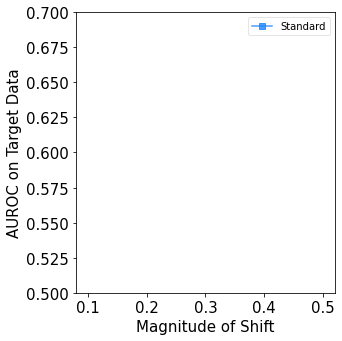

In [40]:
methods_plot = [0]
scatter_metric_shift(all_shift_res, methods, methods_plot, 'roc_auc_test', intv_prop_tar, (0.5,0.7), 'AUROC', 'mimic_roc_auc_us')

shape method, shift, run (4, 2, 1)
Median [[0.81587439 0.79012977]
 [0.82366824 0.81837226]
 [0.811525   0.78625637]
 [0.82130888 0.81741497]]


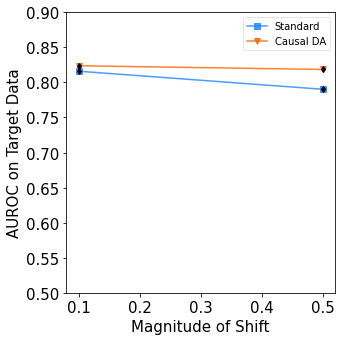

In [42]:
methods_plot = [0,1]
scatter_metric_shift(all_shift_res, methods, methods_plot, 'roc_auc_test', intv_prop_tar, (0.5,0.9), 'AUROC', 'mimic_roc_auc_s')

shape method, shift, run (4, 2, 5)
Median [[0.8134637  0.79648012]
 [0.81888735 0.81576437]
 [0.81212034 0.79471548]
 [0.81742556 0.81615334]]


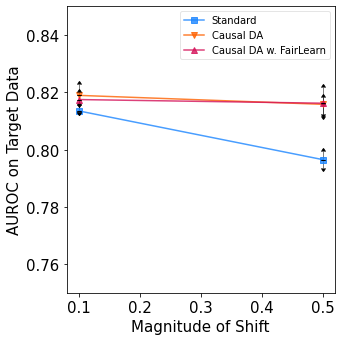

In [47]:
methods_plot = [0,1,3]
scatter_metric_shift(all_shift_res, methods, methods_plot, 'roc_auc_test', intv_prop_tar, (0.75,0.85), 'AUROC', 'mimic_roc_auc_sf')

shape method, shift, run (4, 2, 1)
Median [[0.05600804 0.06748768]
 [0.05582964 0.06654538]
 [0.02896576 0.00977749]
 [0.02078529 0.01951144]]


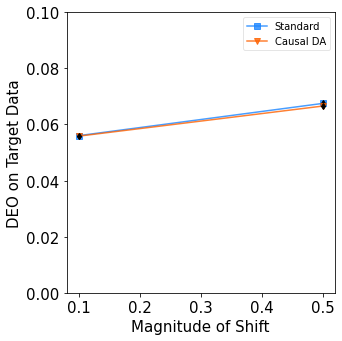

In [25]:
methods_plot = [0,1]
scatter_metric_shift(all_shift_res, methods, methods_plot, 'fair_test', intv_prop_tar, (0.0,0.1), 'DEO', 'mimic_fair_wc')

shape method, shift, run (4, 2, 1)
Median [[0.05600804 0.06748768]
 [0.05582964 0.06654538]
 [0.02896576 0.00977749]
 [0.02078529 0.01951144]]


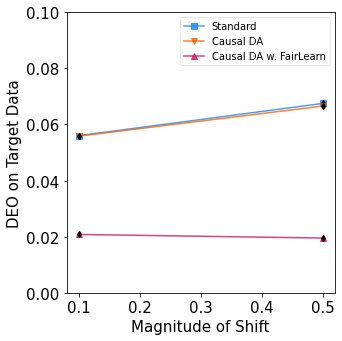

In [26]:
methods_plot = [0,1,3]
scatter_metric_shift(all_shift_res, methods, methods_plot, 'fair_test', intv_prop_tar, (0.0,0.1), 'DEO', 'mimic_fair_c')

shape method, shift, run (4, 5, 25)
Median [[0.86015606 0.85893684 0.85735187 0.85284077 0.85028042]
 [0.86271641 0.86259449 0.86332602 0.86344794 0.86247257]
 [0.8603999  0.85771763 0.85637649 0.84979273 0.84662277]
 [0.8638137  0.86271641 0.86271641 0.8632041  0.86332602]]


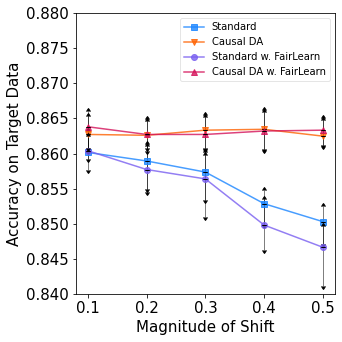

In [12]:
methods_plot = [0,1,2,3]
scatter_metric_shift(all_shift_res, methods, methods_plot, 'acc_test', intv_prop_tar, (0.84,0.88), 'Accuracy', 'mimic_acc_sens_{}'.format(sensible_feature))

shape method, shift, run (4, 5, 25)
Median [[0.80458561 0.79920354 0.79483581 0.79024522 0.78633221]
 [0.80723077 0.80756445 0.80715648 0.80788379 0.80706599]
 [0.80126164 0.79528455 0.79189299 0.78908434 0.78459209]
 [0.80296575 0.80589343 0.80418987 0.80686096 0.80659442]]


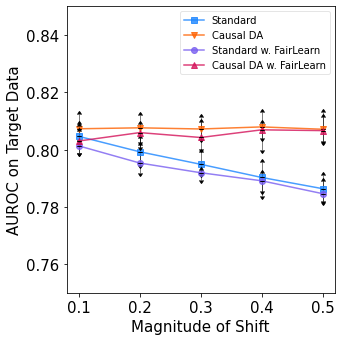

In [13]:
methods_plot = [0,1,2,3]
scatter_metric_shift(all_shift_res, methods, methods_plot, 'roc_auc_test', intv_prop_tar, (0.75,0.85), 'AUROC', 'mimic_roc_auc_sens_{}'.format(sensible_feature))

shape method, shift, run (4, 5, 25)
Median [[0.63945655 0.63448648 0.63112817 0.6234487  0.62209694]
 [0.64689554 0.64738463 0.64650967 0.64711506 0.64619924]
 [0.63738544 0.62563326 0.62827448 0.62078839 0.61637405]
 [0.64038514 0.64392749 0.64089333 0.64390731 0.64237561]]


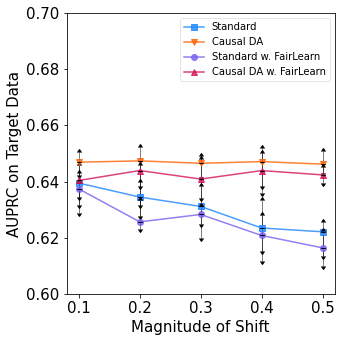

In [14]:
methods_plot = [0,1,2,3]
scatter_metric_shift(all_shift_res, methods, methods_plot, 'auprc_test', intv_prop_tar, (0.6,0.7), 'AUPRC', 'mimic_auprc_sens_{}'.format(sensible_feature))

shape method, shift, run (4, 5, 25)
Median [[0.06873424 0.07089852 0.07296037 0.06994287 0.06668474]
 [0.06519704 0.06641305 0.07037666 0.05965569 0.06965924]
 [0.02909239 0.03339336 0.03056042 0.03106061 0.03288842]
 [0.02863937 0.03756541 0.03859041 0.0377457  0.04659041]]


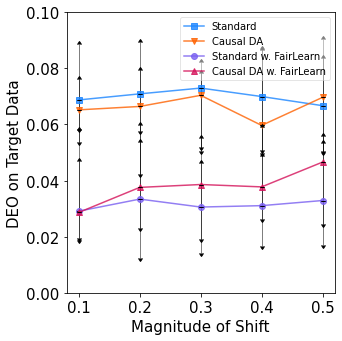

In [15]:
methods_plot = [0,1,2,3]
scatter_metric_shift(all_shift_res, methods, methods_plot, 'fair_test', intv_prop_tar, (0.0,0.1), 'DEO', 'mimic_fair_sens_{}'.format(sensible_feature))

shape method, shift, run (4, 5, 25)
Median [[0.06803675 0.06422877 0.06344791 0.06538069 0.06016596]
 [0.06050907 0.05892731 0.05817642 0.05066058 0.049742  ]
 [0.01073196 0.01078335 0.01137897 0.01047253 0.01081305]
 [0.01133623 0.0107262  0.01231505 0.01102211 0.01120142]]


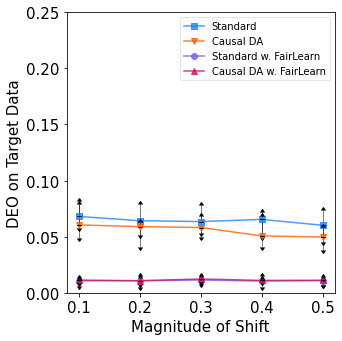

In [16]:
methods_plot = [0,1,2,3]
scatter_metric_shift(all_shift_res, methods, methods_plot, 'fair_train', intv_prop_tar, (0.0,0.25), 'DEO', 'mimic_fair_sens_{}'.format(sensible_feature))

shape method, shift, run (4, 5, 25)
Median [[0.04525532 0.046863   0.04827453 0.0461065  0.04306723]
 [0.04298442 0.04304177 0.04637801 0.03954686 0.04671123]
 [0.01904834 0.02041106 0.02359556 0.0214387  0.02360727]
 [0.01848739 0.02439663 0.02606578 0.02433267 0.02944678]]


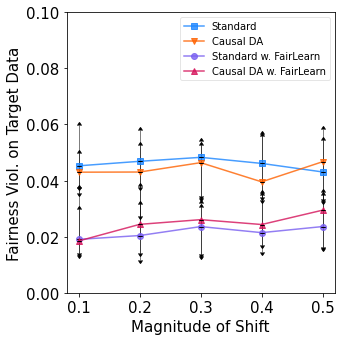

In [18]:
methods_plot = [0,1,2,3]
scatter_metric_shift(all_shift_res, methods, methods_plot, 'maxDEOd_test', intv_prop_tar, (0.0,0.1), 'Fairness Viol.', 'mDEO_fair_sens_{}'.format(sensible_feature))

shape method, shift, run (4, 5, 25)
Median [[0.05398183 0.05074806 0.05025332 0.0518956  0.04711086]
 [0.04791496 0.04609864 0.04635962 0.04047999 0.03974684]
 [0.0093723  0.01002875 0.0091949  0.00970938 0.009355  ]
 [0.0091939  0.00885947 0.01037947 0.00909525 0.00897416]]


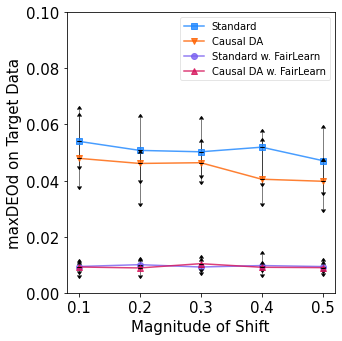

In [29]:
methods_plot = [0,1,2,3]
scatter_metric_shift(all_shift_res, methods, methods_plot, 'maxDEOd_train', intv_prop_tar, (0.0,0.1), 'maxDEOd', 'mDEO_fair_train_sens_{}'.format(sensible_feature))

Median acc [0.80458561 0.80723077 0.80126164 0.80296575]
Median fair [0.06873424 0.06519704 0.02909239 0.02863937]


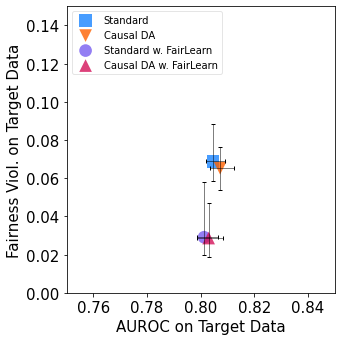

In [20]:
xylim = (0.75,0.85,0.0,0.15)
scatter_metric_fair(all_shift_res, methods, 'roc_auc_test', 'fair_test', intv_prop_tar[0], 0, xylim, 'AUROC', 'mimic_roc_auc_fair_high_sens_{}'.format(sensible_feature))

Median acc [0.78633221 0.80706599 0.78459209 0.80659442]
Median fair [0.06668474 0.06965924 0.03288842 0.04659041]


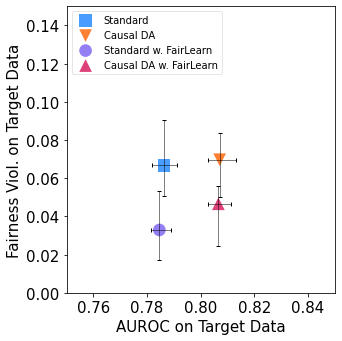

In [21]:
scatter_metric_fair(all_shift_res, methods, 'roc_auc_test', 'fair_test', intv_prop_tar[-1], -1, xylim, 'AUROC', 'mimic_roc_auc_fair_high_sens_{}'.format(sensible_feature))

Median acc [0.78633221 0.80706599 0.78459209 0.80659442]
Median fair [0.04306723 0.04671123 0.02360727 0.02944678]


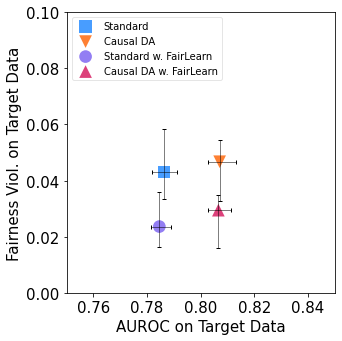

In [22]:
xylim = (0.75,0.85,0.0,0.1)
scatter_metric_fair(all_shift_res, methods, 'roc_auc_test', 'maxDEOd_test', intv_prop_tar[-1], -1, xylim, 'AUROC', 'mimic_roc_auc_maxDEOd_high_sens_{}'.format(sensible_feature))

Median acc [0.80458561 0.80723077 0.80126164 0.80296575]
Median fair [0.04525532 0.04298442 0.01904834 0.01848739]


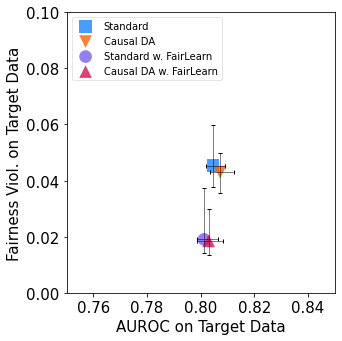

In [23]:
scatter_metric_fair(all_shift_res, methods, 'roc_auc_test', 'maxDEOd_test', intv_prop_tar[0], 0, xylim, 'AUROC', 'mimic_roc_auc_maxDEOd_low_sens_{}'.format(sensible_feature))

Median acc [0.62209694 0.64619924 0.61637405 0.64237561]
Median fair [0.04306723 0.04671123 0.02360727 0.02944678]


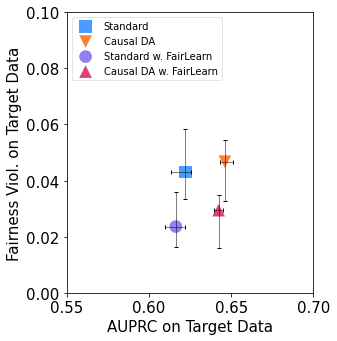

In [25]:
xylim = (0.55,0.7,0.0,0.1)
scatter_metric_fair(all_shift_res, methods, 'auprc_test', 'maxDEOd_test', intv_prop_tar[-1], -1, xylim, 'AUPRC', 'mimic_auprc_maxDEOd_high_sens_{}'.format(sensible_feature))

Median acc [0.63945655 0.64689554 0.63738544 0.64038514]
Median fair [0.04525532 0.04298442 0.01904834 0.01848739]


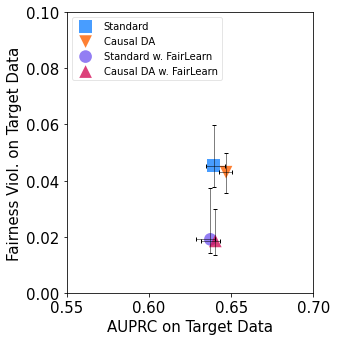

In [26]:
scatter_metric_fair(all_shift_res, methods, 'auprc_test', 'maxDEOd_test', intv_prop_tar[0], 0, xylim, 'AUPRC', 'mimic_auprc_maxDEOd_low_sens_{}'.format(sensible_feature))